# Initial Settings

## Import Packages

In [0]:
# Import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import seaborn as sns

In [0]:
import geopandas as gpd
from geopandas.geoseries import *
from shapely.geometry import Point

In [0]:
# !pip install geopandas

In [0]:
import folium
from folium import plugins
from folium.plugins import HeatMap
import json
import requests

## Mount Gdrive

In [9]:
# Mount your drive here by authorizing access
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Data Preparation

## Loading NYPD Dataset

**To save RAM, I exported the cleaned dataset as a csv. You only need to read this file.**

In [0]:
df = pd.read_csv('/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset.csv')

In [0]:
df_nta = pd.read_csv('/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/nta_character.csv', index_col=0)

In [0]:
# Convert back to datetime object
def convert_to_time_obj(timestamp):
  return datetime.datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S")


df['datetime'] = df['datetime'].map(convert_to_time_obj)

In [0]:
df.head()

,CMPLNT_NUM,datetime,year,month,weekday,hour,LAW_CAT_CD,OFNS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,876525802,2008-04-10 19:10:00,2008,4,Thu,19,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,1008495.0,183171.0,40.669414,-73.912603,"(40.669413836, -73.91260308)"
1,402693528,2007-06-03 15:23:00,2007,6,Sun,15,MISDEMEANOR,DANGEROUS WEAPONS,NaN,NaN,NaN,MANHATTAN,999336.0,231461.0,40.801978,-73.945511,"(40.801978284, -73.945511151)"
2,832030069,2010-02-16 20:50:00,2010,2,Tue,20,FELONY,ROBBERY,NaN,NaN,NaN,QUEENS,1031117.0,194344.0,40.699990,-73.830978,"(40.699990268, -73.830977746)"
3,538308771,2009-11-10 16:35:00,2009,11,Tue,16,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,996722.0,187385.0,40.681005,-73.955035,"(40.681004729, -73.955034577)"
4,965693192,2006-04-11 09:30:00,2006,4,Tue,9,FELONY,THEFT-FRAUD,NaN,NaN,NaN,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN


In [0]:
df_nta.head()
# 'E' means estimated # of population
# 'P' means estimated percentage of people

# we will likely use 'P' for our prediction and EDA

# 'E' is only useful when we want to aggregate several NTAs into PUMA/Boroughs
# because we cannot compute percentage for PUMA if we don't have # of population

,year,GeoID,Borough,PUMA,PopE,MaleE,MaleP,FemE,FemP,hispanicE,hispanicP,whiteE,whiteP,blackE,blackP,asiaE,asiaP,PopUnder15E,PopUnder15P,Pop15to34E,Pop15to34P,Pop35to54E,Pop35to54P,Pop55to74E,Pop55to74P,PopOver75E,PopOver75P,otherRaceE,otherRaceP,employedE,employedP,unemployedE,unemployedP,midincome,not_insE,not_insP,povfamilyE,povfamilyP,povchildE,povchildP,pov65E,pov65P
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,Brooklyn,4004,23945.0,11834.0,49.4,12111.0,50.6,1866.0,7.8,18242.0,76.2,1171.0,4.9,1607.0,6.7,2900.0,12.1,8173.0,34.1,7141.0,29.9,4239.0,17.8,1492.0,6.2,1059.0,4.5,13770.0,65.8,985.0,4.7,105126.0,1536.0,6.4,132.0,2.8,160.0,4.9,271.0,8.8
2013_BK17,2013,BK17,Brooklyn,4016,63033.0,28915.0,45.9,34118.0,54.1,4562.0,7.2,44000.0,69.8,3888.0,6.2,10015.0,15.9,9868.0,15.6,14341.0,22.8,17936.0,28.5,14923.0,23.7,5965.0,9.5,568.0,1.0,27126.0,51.6,2832.0,5.4,50721.0,4450.0,7.1,2271.0,13.5,2631.0,22.2,2528.0,21.6
2013_BK19,2013,BK19,Brooklyn,4018,32442.0,15228.0,46.9,17214.0,53.1,4334.0,13.4,22463.0,69.2,419.0,1.3,4413.0,13.6,4683.0,14.4,7960.0,24.5,8288.0,25.6,7377.0,22.7,4134.0,12.7,813.0,2.5,13258.0,48.4,1146.0,4.2,29690.0,4268.0,13.2,1598.0,20.1,1600.0,28.7,3003.0,42.9
2013_BK21,2013,BK21,Brooklyn,4018,28748.0,13178.0,45.8,15570.0,54.2,6108.0,21.2,8668.0,30.2,9798.0,34.1,3732.0,13.0,4844.0,16.8,7636.0,26.5,6693.0,23.2,6464.0,22.5,3111.0,10.8,442.0,1.6,8797.0,37.5,2403.0,10.2,23324.0,2525.0,9.0,1880.0,28.0,2851.0,45.7,2515.0,45.0
2013_BK23,2013,BK23,Brooklyn,4018,15309.0,6253.0,40.8,9056.0,59.2,121.0,0.8,14894.0,97.3,163.0,1.1,102.0,0.7,1252.0,8.1,2161.0,14.1,3677.0,24.0,5334.0,34.9,2885.0,18.8,29.0,0.2,6581.0,46.9,609.0,4.3,40285.0,1120.0,7.3,355.0,8.2,46.0,3.3,1253.0,22.9


**The following codes are for cleaning data. You can skip to the EDA section.**

In [0]:
dat_whole = pd.read_csv('/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/NYPD_Complaint_Data_Historic.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (18,20) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
dat_whole.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,JURIS_DESC,JURISDICTION_CODE,PARKS_NM,HADEVELOPT,HOUSING_PSA,X_COORD_CD,Y_COORD_CD,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,876525802,04/10/2008,19:10:00,NaN,NaN,73.0,04/10/2008,341,PETIT LARCENY,321.0,"LARCENY,PETIT FROM AUTO",COMPLETED,MISDEMEANOR,BROOKLYN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1008495.0,183171.0,NaN,NaN,NaN,NaN,40.669414,-73.912603,"(40.669413836, -73.91260308)",PATROL BORO BKLYN NORTH,NaN,18-24,BLACK,M
1,402693528,06/03/2007,15:23:00,NaN,NaN,28.0,06/03/2007,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,MANHATTAN,NaN,STREET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,999336.0,231461.0,NaN,NaN,NaN,NaN,40.801978,-73.945511,"(40.801978284, -73.945511151)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E
2,832030069,02/16/2010,20:50:00,02/16/2010,20:50:00,102.0,02/16/2010,105,ROBBERY,375.0,"ROBBERY,PHARMACY",COMPLETED,FELONY,QUEENS,INSIDE,GROCERY/BODEGA,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,1031117.0,194344.0,NaN,NaN,NaN,NaN,40.699990,-73.830978,"(40.699990268, -73.830977746)",PATROL BORO QUEENS SOUTH,NaN,NaN,UNKNOWN,D
3,538308771,11/10/2009,16:35:00,11/10/2009,16:45:00,79.0,11/10/2009,341,PETIT LARCENY,333.0,"LARCENY,PETIT FROM STORE-SHOPL",COMPLETED,MISDEMEANOR,BROOKLYN,INSIDE,FOOD SUPERMARKET,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,996722.0,187385.0,NaN,NaN,NaN,NaN,40.681005,-73.955035,"(40.681004729, -73.955034577)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D
4,965693192,04/11/2006,09:30:00,04/11/2006,10:00:00,123.0,04/25/2006,112,THEFT-FRAUD,739.0,"FRAUD,UNCLASSIFIED-FELONY",COMPLETED,FELONY,STATEN ISLAND,NaN,COMMERCIAL BUILDING,N.Y. POLICE DEPT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PATROL BORO STATEN ISLAND,NaN,25-44,WHITE,M


In [0]:
# Dropping unnecessary variables
drop_var = ['CRM_ATPT_CPTD_CD', 'HADEVELOPT', 'ADDR_PCT_CD', 'HOUSING_PSA',
            'JURISDICTION_CODE', 'JURIS_DESC', 'KY_CD', 'LOC_OF_OCCUR_DESC',
            'PARKS_NM', 'PATROL_BORO', 'PD_CD', 'PD_DESC', 'PREM_TYP_DESC',
            'RPT_DT', 'STATION_NAME', 'TRANSIT_DISTRICT', 'VIC_AGE_GROUP',
            'VIC_RACE', 'VIC_SEX']
dat_dropped = dat_whole.drop(columns=drop_var)
# dat_dropped

## Cleaning NYPD Dataset

### Missing Timestamps

In [0]:
# How many NaN?
dat_dropped[['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM']].isnull().sum()

CMPLNT_FR_DT        655
CMPLNT_FR_TM         48
CMPLNT_TO_DT    1651735
CMPLNT_TO_TM    1647257
dtype: int64

There are two different timestamps in this dataset. The "From" datetime means the exact datetime when the crime incident was reported to occur or start. In very rare cases, some incidents only contain the "To" datetime, which indicate only a known endpoint to the crime.

We only use the "From" datetime for our analysis. However, there is a small number of missing values (less than 700 rows) in the "From" timestamps. In such cases, we substitute the "To" datetime for the "From" datetime.

In [0]:
# Substitute the "To" datetime
dat_dropped.loc[dat_dropped['CMPLNT_FR_DT'].isnull(), 'CMPLNT_FR_DT'] = dat_dropped['CMPLNT_TO_DT']
dat_dropped.loc[dat_dropped['CMPLNT_FR_TM'].isnull(), 'CMPLNT_FR_TM'] = dat_dropped['CMPLNT_TO_TM']

In [0]:
dat_dropped[['CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM']].isnull().sum()

CMPLNT_FR_DT        147
CMPLNT_FR_TM         12
CMPLNT_TO_DT    1651735
CMPLNT_TO_TM    1647257
dtype: int64

After substituting the "To" datetime, we still have less than 200 observations with missing "From" timestamps. Given we have over 6 million datapoints, we can drop and ignore these rows.

In [0]:
# Dropping the rows with missing "From" timestamps 
dat_sbst = dat_dropped.dropna(subset=['CMPLNT_FR_DT', 'CMPLNT_FR_TM'])
# We no longer need the "To" datetime
drop_var2 = ['CMPLNT_TO_DT', 'CMPLNT_TO_TM']
dat_cleaned = dat_sbst.drop(columns=drop_var2)

### Year, Month, Weekday, and Hour
We want to make the timestamps easier to interpret. We convert the timestamps to `datetime` objects and create new columns "Year," "Month," "Weekday," and "Hour."

In [0]:
def to_datetime_obj(datestr):
  return datetime.datetime.strptime(datestr, '%m/%d/%Y %H:%M:%S')


def display_dayofweek(date_obj):
  dayofweek = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
  return dayofweek[date_obj.weekday()]


def display_year(datetime_obj):
  return datetime_obj.year


def display_month(datetime_obj):
  return datetime_obj.month


def display_hour(datetime_obj):
  return datetime_obj.hour

In [0]:
# Convert timestamps
dat_cleaned['datetime'] = dat_cleaned['CMPLNT_FR_DT'] + ' ' + dat_cleaned['CMPLNT_FR_TM']
dat_cleaned['datetime'] = dat_cleaned['datetime'].map(to_datetime_obj)
dat_cleaned['year'] = dat_cleaned['datetime'].map(display_year)
dat_cleaned['month'] = dat_cleaned['datetime'].map(display_month)
dat_cleaned['weekday'] = dat_cleaned['datetime'].map(display_dayofweek)
dat_cleaned['hour'] = dat_cleaned['datetime'].map(display_hour)

In [0]:
# Drop original Date and Time, and sort columns
dat_cleaned = dat_cleaned[['CMPLNT_NUM', 'datetime', 'year', 'month', 'weekday', 'hour',
                   'LAW_CAT_CD', 'OFNS_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX',
                   'BORO_NM','X_COORD_CD','Y_COORD_CD','Latitude', 'Longitude', 'Lat_Lon']]

After converting the timestamps, we noticed that this dataset also contains records before 2006. There are only 1 to 10,000 records for each year before 2006. We drop all the records in or before 2005.

In [0]:
dat_cleaned['year'].value_counts()[2005]

10760

In [0]:
dat_cleaned = dat_cleaned[dat_cleaned['year'] >= 2006]

### Notes on Other Missing Values

We still have missing values in columns such as the name of boroughs and coordinates where the incident occurred, but we continue using these rows for our exploratory data analysis to understand temporal trends in crimes. We will drop rows without any location information when conducting a geographical analysis.

In [0]:
dat_cleaned[['BORO_NM', 'Latitude', 'Longitude']].isnull().sum()

BORO_NM       10588
Latitude     338837
Longitude    338837
dtype: int64

In [0]:
pd.DataFrame(dat_cleaned['Longitude'].isnull().groupby(dat_cleaned['year']).sum().astype(int))

,Longitude
year,
2006,16459
2007,288
2008,124
2009,46
2010,71
2011,54
2012,73
2013,96
2014,129


Also, roughly 50% of the descriptions of suspects are missing. However, the number of missing values has been decreasing over the past few years. We try to use these variables for EDA by focusing mostly on recent years.

In [0]:
dat_cleaned[['OFNS_DESC', 'SUSP_AGE_GROUP', 'SUSP_RACE', 'SUSP_SEX']].isnull().sum()

OFNS_DESC           18755
SUSP_AGE_GROUP    4657277
SUSP_RACE         3293549
SUSP_SEX          3425898
dtype: int64

In [0]:
dat_cleaned[['year', 'SUSP_AGE_GROUP']].groupby('year').agg({'SUSP_AGE_GROUP': lambda x: x.isnull().sum()})

,SUSP_AGE_GROUP
year,
2006,454020
2007,465318
2008,460412
2009,443190
2010,442278
2011,433672
2012,437314
2013,426272
2014,390391


**To save RAM, I exported the cleaned dataset above as a csv file. You only need to read this csv when conducting the following analysis.**

In [0]:
dat_cleaned.head()

,CMPLNT_NUM,datetime,year,month,weekday,hour,LAW_CAT_CD,OFNS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,876525802,2008-04-10 19:10:00,2008,4,Thu,19,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,1008495.0,183171.0,40.669414,-73.912603,"(40.669413836, -73.91260308)"
1,402693528,2007-06-03 15:23:00,2007,6,Sun,15,MISDEMEANOR,DANGEROUS WEAPONS,NaN,NaN,NaN,MANHATTAN,999336.0,231461.0,40.801978,-73.945511,"(40.801978284, -73.945511151)"
2,832030069,2010-02-16 20:50:00,2010,2,Tue,20,FELONY,ROBBERY,NaN,NaN,NaN,QUEENS,1031117.0,194344.0,40.699990,-73.830978,"(40.699990268, -73.830977746)"
3,538308771,2009-11-10 16:35:00,2009,11,Tue,16,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,996722.0,187385.0,40.681005,-73.955035,"(40.681004729, -73.955034577)"
4,965693192,2006-04-11 09:30:00,2006,4,Tue,9,FELONY,THEFT-FRAUD,NaN,NaN,NaN,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN


In [0]:
dat_cleaned.to_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset.csv', index = False, header=True)

## Load Extra Datasets

### Demographic characteristics

In [0]:
def get_nta_df(kind, year):
  ParentPath = '/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/ACS_by_NTA'
  return pd.read_excel(f'{ParentPath}/{kind}/{kind}_{year}acs5yr_nta.xlsx', sheet_name=0)

In [0]:
# Note that there are 7 NTAs we must exclude from our analysis.
# They are parks, prisons, etc.
special_ntas = ['BX99', 'BX98', 'BK99', 'MN99', 'QN99', 'SI99', 'QN98']

In [0]:
def clean_nta_demo(df):
  df1 = df[df.columns[[2,4,9,12,14,17,19,22,24,27,29,32,34,37,39,42,44,47,49,52,
                   54,57,59,62,64,67,69,72,74,77,79,82]]]
  df2 = df[['GeoID', 'Hsp1E', 'Hsp1P', 'WtNHE', 'WtNHP', 'BlNHE', 'BlNHP',
            'AIANNHE', 'AIANNHP', 'AsnNHE', 'AsnNHP', 'NHPINHE', 'NHPINHP',
            'OthNHE', 'OthNHP','Rc2plNHE', 'Rc2plNHP']]
  df = pd.merge(df1, df2, on='GeoID')
  df.rename(columns={'Pop1E': 'PopE', 'Hsp1E': 'HspE', 'Hsp1P': 'HspP'}, inplace=True)
  return df


def summarize_nta_demo(df):
  # NaN values can be considered as 0 (such as Airport area)
  df = df.fillna(0)
  # change age group
  df['PopUnder15E'] = df['PopU5E'] + df['Pop5t9E'] + df['Pop10t14E']
  df['PopUnder15P'] = df['PopU5P'] + df['Pop5t9P'] + df['Pop10t14P']
  df['Pop15to34E'] = df['Pop15t19E'] + df['Pop20t24E'] + df['Pop25t34E']
  df['Pop15to34P'] = df['Pop15t19P'] + df['Pop20t24P'] + df['Pop25t34P']
  df['Pop35to54E'] = df['Pop35t44E'] + df['Pop45t54E']
  df['Pop35to54P'] = df['Pop35t44P'] + df['Pop45t54P']
  df['Pop55to74E'] = df['Pop55t59E'] + df['Pop60t64E'] + df['Pop65t74E']
  df['Pop55to74P'] = df['Pop55t59P'] + df['Pop60t64P'] + df['Pop65t74P']
  df['PopOver75E'] = df['Pop75t84E'] + df['Pop85plE']
  df['PopOver75P'] = df['Pop75t84P'] + df['Pop85plP']
  # suming race groups with relatively small number
  df['otherRaceE'] = df['AIANNHE'] + df['NHPINHE'] + df['OthNHE'] + df['Rc2plNHE']
  df['otherRaceP'] = df['AIANNHP'] + df['NHPINHP'] + df['OthNHP'] + df['Rc2plNHP']
  # rename
  df.rename(columns={'HspE': 'hispanicE', 'HspP': 'hispanicP',
                     'WtNHE': 'whiteE', 'WtNHP': 'whiteP',
                     'BlNHE': 'blackE', 'BlNHP': 'blackP',
                     'AsnNHE': 'asiaE', 'AsnNHP': 'asiaP'}, inplace=True)
  # drop unnecessary columns
  drop_var = ['PopU5E', 'PopU5P', 'Pop5t9E', 'Pop5t9P', 'Pop10t14E', 'Pop10t14P',
       'Pop15t19E', 'Pop15t19P', 'Pop20t24E', 'Pop20t24P', 'Pop25t34E',
       'Pop25t34P', 'Pop35t44E', 'Pop35t44P', 'Pop45t54E', 'Pop45t54P',
       'Pop55t59E', 'Pop55t59P', 'Pop60t64E', 'Pop60t64P', 'Pop65t74E',
       'Pop65t74P', 'Pop75t84E', 'Pop75t84P', 'Pop85plE', 'Pop85plP',
       'AIANNHE', 'AIANNHP', 'NHPINHE', 'NHPINHP', 'OthNHE', 'OthNHP',
       'Rc2plNHE', 'Rc2plNHP']
  df = df.drop(columns=drop_var)
  return df

In [0]:
# 2013 format is very different from other years
# 2013 format also contains borough name and PUMA name
nta_demo_2013 = get_nta_df('demo', '2013')
nta_demo_2013 = nta_demo_2013[nta_demo_2013.columns[[2,3,4,6,11,14,16,19,21,24,
                                                     26,29,31,34,36,39,41,44,46,
                                                     49,51,54,56,59,61,64,66,69,
                                                     71,74,76,79,81,84,126,129,
                                                     156,159,161,164,166,169,
                                                     171,174,176,179,181,184,
                                                     186,189]]]
nta_demo_2013.insert(0, 'year', 2013)
nta_demo_2013 = summarize_nta_demo(nta_demo_2013)

In [0]:
# We write the function based on 2014 format.
nta_demo_2014 = get_nta_df('demo', '2014')
nta_demo_2014 = clean_nta_demo(nta_demo_2014)
nta_demo_2014.insert(0, 'year', 2014)
nta_demo_2014 = summarize_nta_demo(nta_demo_2014)

In [0]:
# 2015 format is similar to 2014 format but a bit different. we tweak the function
def clean_nta_demo_after_2015(df):
  df1 = df[df.columns[[2,4,9,12,14,17,19,22,24,27,29,32,34,37,39,42,44,47,49,52,
                   54,57,59,62,64,67,69,72,74,77,79,82,84,87,89,92,94,97,99,102,
                   104,107]]]
  df2 = df[['GeoID', 'Hsp1E', 'Hsp1P', 'WtNHE', 'WtNHP', 'BlNHE', 'BlNHP',
            'AIANNHE', 'AIANNHP', 'AsnNHE', 'AsnNHP', 'NHPINHE', 'NHPINHP',
            'OthNHE', 'OthNHP','Rc2plNHE', 'Rc2plNHP']]
  df = pd.merge(df1, df2, on='GeoID')
  df.rename(columns={'Pop1E': 'PopE', 'Hsp1E': 'HspE', 'Hsp1P': 'HspP'}, inplace=True)
  return df

# we also need to merge some age groups because they are also different from 2013-2014
def merge_age_after_2015(df):
  df['Pop25t34E'] = df['Pop25t29E'] + df['Pop30t34E']
  df['Pop25t34P'] = df['Pop25t29P'] + df['Pop30t34P']

  df['Pop35t44E'] = df['Pop35t39E'] + df['Pop40t44E']
  df['Pop35t44P'] = df['Pop35t39P'] + df['Pop40t44P']

  df['Pop45t54E'] = df['Pop45t49E'] + df['Pop50t54E']
  df['Pop45t54P'] = df['Pop45t49P'] + df['Pop50t54P']

  df['Pop65t74E'] = df['Pop65t69E'] + df['Pop70t74E']
  df['Pop65t74P'] = df['Pop65t69P'] + df['Pop70t74P']

  df['Pop75t84E'] = df['Pop75t79E'] + df['Pop80t84E']
  df['Pop75t84P'] = df['Pop75t79P'] + df['Pop80t84P']

  drop_var = ['Pop25t29E', 'Pop25t29P', 'Pop30t34E', 'Pop30t34P', 'Pop35t39E',
              'Pop35t39P', 'Pop40t44E', 'Pop40t44P', 'Pop45t49E', 'Pop45t49P',
              'Pop50t54E', 'Pop50t54P', 'Pop65t69E',
              'Pop65t69P', 'Pop70t74E', 'Pop70t74P', 'Pop75t79E', 'Pop75t79P',
              'Pop80t84E', 'Pop80t84P']
  df = df.drop(columns=drop_var)

  return df

In [0]:
# 2015
nta_demo_2015 = get_nta_df('demo', '2015')
nta_demo_2015.rename(columns={'Pop_1E': 'Pop1E'}, inplace=True)
nta_demo_2015 = clean_nta_demo_after_2015(nta_demo_2015)
nta_demo_2015 = summarize_nta_demo(merge_age_after_2015(nta_demo_2015))
nta_demo_2015.insert(0, 'year', 2015)
# 2016 & 2017 format is identical to 2015
nta_demo_2016 = get_nta_df('demo', '2016')
nta_demo_2016.rename(columns={'Pop_1E': 'Pop1E'}, inplace=True)
nta_demo_2016 = clean_nta_demo_after_2015(nta_demo_2016)
nta_demo_2016.insert(0, 'year', 2016)
nta_demo_2016 = summarize_nta_demo(merge_age_after_2015(nta_demo_2016))
# 2017
nta_demo_2017 = get_nta_df('demo', '2017')
nta_demo_2017.rename(columns={'Pop_1E': 'Pop1E'}, inplace=True)
nta_demo_2017 = clean_nta_demo_after_2015(nta_demo_2017)
nta_demo_2017.insert(0, 'year', 2017)
nta_demo_2017 = summarize_nta_demo(merge_age_after_2015(nta_demo_2017))

In [0]:
# add columns "Borough", "PUMA"
def get_borough(nta):
  return nta_demo_2013[nta_demo_2013['GeoID'] == nta].iat[0,2]


def get_PUMA(nta):
  return nta_demo_2013[nta_demo_2013['GeoID'] == nta].iat[0,3]


def assign_boro_puma(df):
  df['Borough'] = df['GeoID'].map(get_borough)
  df['PUMA'] = df['GeoID'].map(get_PUMA)
  return df

nta_demo_2014 = assign_boro_puma(nta_demo_2014)
nta_demo_2015 = assign_boro_puma(nta_demo_2015)
nta_demo_2016 = assign_boro_puma(nta_demo_2016)
nta_demo_2017 = assign_boro_puma(nta_demo_2017)

In [0]:
# merge all
nta_demo = pd.concat([nta_demo_2013, nta_demo_2014, nta_demo_2015,
                      nta_demo_2016, nta_demo_2017])
# generate index
nta_demo['nta_index'] = nta_demo['year'].astype(str) + '_' + nta_demo['GeoID']
nta_demo.set_index('nta_index', inplace=True)
# exclude special cases
nta_demo = nta_demo[~nta_demo['GeoID'].isin(special_ntas)]

nta_demo.head()

,year,GeoID,Borough,PUMA,PopE,MaleE,MaleP,FemE,FemP,hispanicE,hispanicP,whiteE,whiteP,blackE,blackP,asiaE,asiaP,PopUnder15E,PopUnder15P,Pop15to34E,Pop15to34P,Pop35to54E,Pop35to54P,Pop55to74E,Pop55to74P,PopOver75E,PopOver75P,otherRaceE,otherRaceP
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,Brooklyn,4004,23945.0,11834.0,49.4,12111.0,50.6,1866.0,7.8,18242.0,76.2,1171.0,4.9,1607.0,6.7,2900.0,12.1,8173.0,34.1,7141.0,29.9,4239.0,17.8,1492.0,6.2,1059.0,4.5
2013_BK17,2013,BK17,Brooklyn,4016,63033.0,28915.0,45.9,34118.0,54.1,4562.0,7.2,44000.0,69.8,3888.0,6.2,10015.0,15.9,9868.0,15.6,14341.0,22.8,17936.0,28.5,14923.0,23.7,5965.0,9.5,568.0,1.0
2013_BK19,2013,BK19,Brooklyn,4018,32442.0,15228.0,46.9,17214.0,53.1,4334.0,13.4,22463.0,69.2,419.0,1.3,4413.0,13.6,4683.0,14.4,7960.0,24.5,8288.0,25.6,7377.0,22.7,4134.0,12.7,813.0,2.5
2013_BK21,2013,BK21,Brooklyn,4018,28748.0,13178.0,45.8,15570.0,54.2,6108.0,21.2,8668.0,30.2,9798.0,34.1,3732.0,13.0,4844.0,16.8,7636.0,26.5,6693.0,23.2,6464.0,22.5,3111.0,10.8,442.0,1.6
2013_BK23,2013,BK23,Brooklyn,4018,15309.0,6253.0,40.8,9056.0,59.2,121.0,0.8,14894.0,97.3,163.0,1.1,102.0,0.7,1252.0,8.1,2161.0,14.1,3677.0,24.0,5334.0,34.9,2885.0,18.8,29.0,0.2


### Economic characteristics

In [0]:
def get_econ_columns(df):
  df = df[['GeoID', 'CvEm16plE', 'CvEm16plP', 'CvLFUEmE', 'CvLFUEmP', 'MdHHIncE',
          'NHInsE', 'NHInsP', 'FamBwPvE', 'FamBwPvP', 'PU18BwPvE', 'PU18BwPvP',
           'P65plBwPvE', 'P65plBwPvP']]
  return df

# The names of some columns changed in 2014
def rename_columns_after_2014(df):
  df.rename(columns={'CvEm16pl1E': 'CvEm16plE', 'CvEm16pl1P': 'CvEm16plP',
                     'CvLFUEm1E': 'CvLFUEmE', 'CvLFUEm1P': 'CvLFUEmP'},
            inplace=True)
  return df

def rename_econ_columns(df):
  df.rename(columns={'CvEm16plE': 'employedE', 'CvEm16plP': 'employedP',
                     'CvLFUEmE': 'unemployedE', 'CvLFUEmP' : 'unemployedP',
                     'MdHHIncE' : 'midincome', 'NHInsE' : 'not_insE',
                     'NHInsP' :'not_insP', 'FamBwPvE' :'povfamilyE',
                     'FamBwPvP' :'povfamilyP', 'PU18BwPvE':'povchildE',
                     'PU18BwPvP' :'povchildP', 'P65plBwPvE':'pov65E',
                     'P65plBwPvP' :'pov65P'}, inplace=True)
  return df

In [0]:
nta_econ_2013 = get_nta_df('econ', '2013')
nta_econ_2013 = get_econ_columns(nta_econ_2013)
nta_econ_2013 = nta_econ_2013[~nta_econ_2013['GeoID'].isin(special_ntas)]
nta_econ_2013 = rename_econ_columns(nta_econ_2013)
nta_econ_2013.insert(0, 'year', 2013)

nta_econ_2014 = get_nta_df('econ', '2014')
nta_econ_2014 = get_econ_columns(rename_columns_after_2014(nta_econ_2014))
nta_econ_2014 = nta_econ_2014[~nta_econ_2014['GeoID'].isin(special_ntas)]
nta_econ_2014 = rename_econ_columns(nta_econ_2014)
nta_econ_2014.insert(0, 'year', 2014)

nta_econ_2015 = get_nta_df('econ', '2015')
nta_econ_2015 = get_econ_columns(rename_columns_after_2014(nta_econ_2015))
nta_econ_2015 = nta_econ_2015[~nta_econ_2015['GeoID'].isin(special_ntas)]
nta_econ_2015 = rename_econ_columns(nta_econ_2015)
nta_econ_2015.insert(0, 'year', 2015)

nta_econ_2016 = get_nta_df('econ', '2016')
nta_econ_2016 = get_econ_columns(rename_columns_after_2014(nta_econ_2016))
nta_econ_2016 = nta_econ_2016[~nta_econ_2016['GeoID'].isin(special_ntas)]
nta_econ_2016 = rename_econ_columns(nta_econ_2016)
nta_econ_2016.insert(0, 'year', 2016)

nta_econ_2017 = get_nta_df('econ', '2017')
nta_econ_2017 = get_econ_columns(rename_columns_after_2014(nta_econ_2017))
nta_econ_2017 = nta_econ_2017[~nta_econ_2017['GeoID'].isin(special_ntas)]
nta_econ_2017 = rename_econ_columns(nta_econ_2017)
nta_econ_2017.insert(0, 'year', 2017)

In [0]:
# merge all econ
nta_econ = pd.concat([nta_econ_2013, nta_econ_2014, nta_econ_2015,
                      nta_econ_2016, nta_econ_2017])
# generate index
nta_econ['nta_index'] = nta_econ['year'].astype(str) + '_' + nta_econ['GeoID']
nta_econ.set_index('nta_index', inplace=True)
nta_econ

,year,GeoID,employedE,employedP,unemployedE,unemployedP,midincome,not_insE,not_insP,povfamilyE,povfamilyP,povchildE,povchildP,pov65E,pov65P
nta_index,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,13770.0,65.8,985.0,4.7,105126.0,1536.0,6.4,132.0,2.8,160.0,4.9,271.0,8.8
2013_BK17,2013,BK17,27126.0,51.6,2832.0,5.4,50721.0,4450.0,7.1,2271.0,13.5,2631.0,22.2,2528.0,21.6
2013_BK19,2013,BK19,13258.0,48.4,1146.0,4.2,29690.0,4268.0,13.2,1598.0,20.1,1600.0,28.7,3003.0,42.9
2013_BK21,2013,BK21,8797.0,37.5,2403.0,10.2,23324.0,2525.0,9.0,1880.0,28.0,2851.0,45.7,2515.0,45.0
2013_BK23,2013,BK23,6581.0,46.9,609.0,4.3,40285.0,1120.0,7.3,355.0,8.2,46.0,3.3,1253.0,22.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017_SI32,2017,SI32,10755.0,60.1,416.0,2.3,96666.0,633.0,2.9,467.0,7.6,477.0,10.0,319.0,9.6
2017_SI37,2017,SI37,11533.0,54.4,755.0,3.6,53527.0,2521.0,9.7,1203.0,19.0,2106.0,34.9,471.0,15.2
2017_SI24,2017,SI24,14692.0,54.4,802.0,3.0,82914.0,1926.0,6.1,521.0,6.0,715.0,11.8,531.0,9.0


### Output cleaned csv

In [0]:
nta_char = nta_demo.join(nta_econ.drop(columns=['year', 'GeoID']))
nta_char.head()

,year,GeoID,Borough,PUMA,PopE,MaleE,MaleP,FemE,FemP,hispanicE,hispanicP,whiteE,whiteP,blackE,blackP,asiaE,asiaP,PopUnder15E,PopUnder15P,Pop15to34E,Pop15to34P,Pop35to54E,Pop35to54P,Pop55to74E,Pop55to74P,PopOver75E,PopOver75P,otherRaceE,otherRaceP,employedE,employedP,unemployedE,unemployedP,midincome,not_insE,not_insP,povfamilyE,povfamilyP,povchildE,povchildP,pov65E,pov65P
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,Brooklyn,4004,23945.0,11834.0,49.4,12111.0,50.6,1866.0,7.8,18242.0,76.2,1171.0,4.9,1607.0,6.7,2900.0,12.1,8173.0,34.1,7141.0,29.9,4239.0,17.8,1492.0,6.2,1059.0,4.5,13770.0,65.8,985.0,4.7,105126.0,1536.0,6.4,132.0,2.8,160.0,4.9,271.0,8.8
2013_BK17,2013,BK17,Brooklyn,4016,63033.0,28915.0,45.9,34118.0,54.1,4562.0,7.2,44000.0,69.8,3888.0,6.2,10015.0,15.9,9868.0,15.6,14341.0,22.8,17936.0,28.5,14923.0,23.7,5965.0,9.5,568.0,1.0,27126.0,51.6,2832.0,5.4,50721.0,4450.0,7.1,2271.0,13.5,2631.0,22.2,2528.0,21.6
2013_BK19,2013,BK19,Brooklyn,4018,32442.0,15228.0,46.9,17214.0,53.1,4334.0,13.4,22463.0,69.2,419.0,1.3,4413.0,13.6,4683.0,14.4,7960.0,24.5,8288.0,25.6,7377.0,22.7,4134.0,12.7,813.0,2.5,13258.0,48.4,1146.0,4.2,29690.0,4268.0,13.2,1598.0,20.1,1600.0,28.7,3003.0,42.9
2013_BK21,2013,BK21,Brooklyn,4018,28748.0,13178.0,45.8,15570.0,54.2,6108.0,21.2,8668.0,30.2,9798.0,34.1,3732.0,13.0,4844.0,16.8,7636.0,26.5,6693.0,23.2,6464.0,22.5,3111.0,10.8,442.0,1.6,8797.0,37.5,2403.0,10.2,23324.0,2525.0,9.0,1880.0,28.0,2851.0,45.7,2515.0,45.0
2013_BK23,2013,BK23,Brooklyn,4018,15309.0,6253.0,40.8,9056.0,59.2,121.0,0.8,14894.0,97.3,163.0,1.1,102.0,0.7,1252.0,8.1,2161.0,14.1,3677.0,24.0,5334.0,34.9,2885.0,18.8,29.0,0.2,6581.0,46.9,609.0,4.3,40285.0,1120.0,7.3,355.0,8.2,46.0,3.3,1253.0,22.9


In [0]:
nta_char.to_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/nta_character.csv', index = True, header=True)

## Matching latitude&longitude coordinates with NTA names

This part is computatinally super heavy. Do not re-run.

In [0]:
# # read shapefile
# df_sh = gpd.read_file('/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/Neighborhood_Tabulation_Areas_Shapefile/nynta_19a/nynta.shp')

In [0]:
# # Function for converting coordinates to NTA name
# def reverse_geo2(lon,lat):
#     polygon = df_sh['geometry']
#     if (np.isnan(lon)) or (np.isnan(lat)):
#         return(np.nan)
#     point = Point(lon, lat)

#     try:
#         whichtrue = polygon.contains(point)
#         whichrow = whichtrue[whichtrue == True].index
#         geos = df_sh['NTACode'][whichrow[0]]
#     except IndexError:
#         return(np.nan)
#     else:
#         return(geos)

In [0]:
# # Function for Writing out cleaned csv files for each year
# def matched_nta_csv(df, year):
#   data_year = df[df['year']==year]
#   xcoord_list = data_year.X_COORD_CD.to_list()
#   ycoord_list = data_year.Y_COORD_CD.to_list()
#   area_list = []
#   for x_coord, y_coord in zip(xcoord_list, ycoord_list):
#     area = reverse_geo2(x_coord, y_coord)
#     area_list.append(area)
#   data_year.loc[:, 'NTACode'] = area_list
#   data_year.to_csv(f'cleaned_dataset_{year}.csv', index = False, header=True)

In [0]:
# matched_nta_csv(df, 2012)
# matched_nta_csv(df, 2013)
# matched_nta_csv(df, 2014)
# matched_nta_csv(df, 2015)
# matched_nta_csv(df, 2016)
# matched_nta_csv(df, 2017)

# Exploratory Data Analysis

In [0]:
# You can use the cleaned dataframe for EDA!
df.head()

,CMPLNT_NUM,datetime,year,month,weekday,hour,LAW_CAT_CD,OFNS_DESC,SUSP_AGE_GROUP,SUSP_RACE,SUSP_SEX,BORO_NM,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,876525802,2008-04-10 19:10:00,2008,4,Thu,19,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,1008495.0,183171.0,40.669414,-73.912603,"(40.669413836, -73.91260308)"
1,402693528,2007-06-03 15:23:00,2007,6,Sun,15,MISDEMEANOR,DANGEROUS WEAPONS,NaN,NaN,NaN,MANHATTAN,999336.0,231461.0,40.801978,-73.945511,"(40.801978284, -73.945511151)"
2,832030069,2010-02-16 20:50:00,2010,2,Tue,20,FELONY,ROBBERY,NaN,NaN,NaN,QUEENS,1031117.0,194344.0,40.699990,-73.830978,"(40.699990268, -73.830977746)"
3,538308771,2009-11-10 16:35:00,2009,11,Tue,16,MISDEMEANOR,PETIT LARCENY,NaN,NaN,NaN,BROOKLYN,996722.0,187385.0,40.681005,-73.955035,"(40.681004729, -73.955034577)"
4,965693192,2006-04-11 09:30:00,2006,4,Tue,9,FELONY,THEFT-FRAUD,NaN,NaN,NaN,STATEN ISLAND,NaN,NaN,NaN,NaN,NaN


### EDA Ideas
- Change in # of crimes since 2006? breakdown in level of offence ("LAW_CAT_CD")  
should have been rapidly decreasing in the past few years
- Which month has the highest number of crimes in 2019/2014/2009?
- which week of the day has the highest number of crimes in 2019/2014/2009?  
maybe friday?  
Time/Day of the week heat map must be interesting
- In what time do crimes occur in 2019/2014/2009?
- drawing crime heat map using latitude and longitude







### Temporal Trends of Crimes
Because each incident has timestamps, we can visualize trends over time using heatmaps.

We formatted the timestamps as `datetime` objects. The datetime module in python supplies classes for manipulating dates and times. We aggregate number of crimes by year, month, week of the day, and time, and visualize them in order to find trends over time.

First of all, we visualize yearly changes of count of crimes. The number of crimes is slowly decreasing. Note that this dataset only contains crimes up to September 2019.

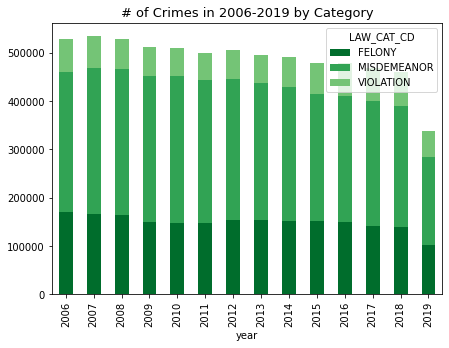

In [0]:
colors = ["#006D2C", "#31A354","#74C476"]
stacked_df = df.groupby(['year', 'LAW_CAT_CD']).count()
stacked_df = stacked_df.reset_index().pivot(index='year', columns='LAW_CAT_CD', values='CMPLNT_NUM')
stacked_df.plot.bar(stacked=True, color=colors, figsize=(7,5))
plt.title('# of Crimes in 2006-2019 by Category', fontsize=13)
plt.show()

By using the `seaborn` packages and its `heatmap()` function, we can easily generate a heatmap over time. The count of crimes per month over the years 2006 to 2019 is shown below. Agaiun, we can see that the number of crimes keeps decreasing. There are not obvious trends between months, but the number of crimes is relatively higher in midyear (around May to September).

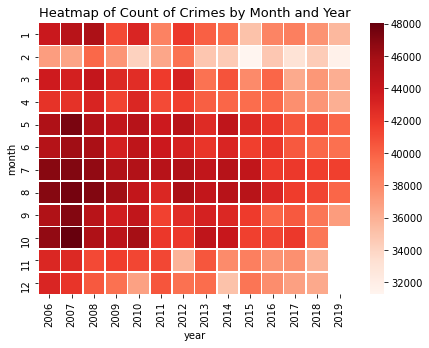

In [0]:
yearly_table = df['datetime'].groupby([df['datetime'].dt.year.rename('year'),
                                       df['datetime'].dt.month.rename('month')]).agg({'count'})
yearly_table = yearly_table.reset_index().pivot('month', 'year', 'count')

f, ax = plt.subplots(figsize=(7, 5))
sns.heatmap(yearly_table, annot=False, fmt="f", linewidths=.5, ax=ax, cmap="Reds")
ax.axes.set_title("Heatmap of Count of Crimes by Month and Year", fontsize=13, y=1.01);

Next, we plot the number of crimes by day of week and hour of day. There are obvious patterns. The safest time in a day is the early morning, and the number of crimes keeps increasing toward the evening.  
The number of crimes is at the highest around 6 PM of Friday.

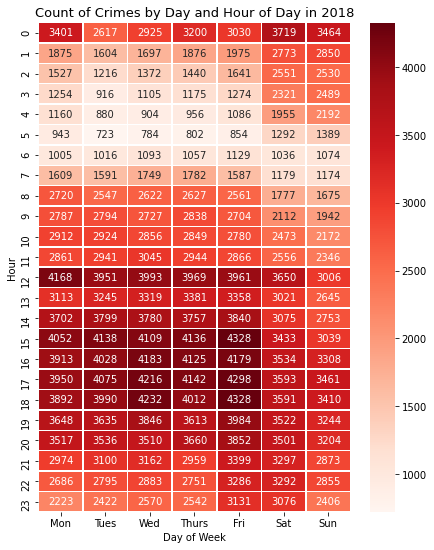

In [0]:
day_short_names = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
weekly_table = df[df['year'] == 2018]['datetime'].groupby([df['datetime'].dt.weekday.rename('weekday'),
                                       df['datetime'].dt.hour.rename('hour')]).agg({'count'})
weekly_table = weekly_table.reset_index().pivot('hour', 'weekday', 'count')

f, ax = plt.subplots(figsize=(7, 9))
ax = sns.heatmap(weekly_table, annot=True, fmt="d", linewidths=.5, ax=ax,
                 xticklabels=day_short_names,  cmap="Reds")
ax.axes.set_title("Count of Crimes by Day and Hour of Day in 2018",
                  fontsize=13, y=1.01)
ax.set(xlabel='Day of Week', ylabel='Hour');

## Difference between Boroughs

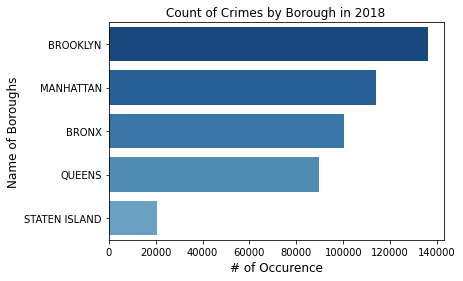

In [0]:
boroughs_2018 = df[df['year'] == 2018]['BORO_NM'].value_counts()
plt.figure()
sns.barplot(boroughs_2018.values, boroughs_2018.index,
            palette=sns.color_palette("Blues_r",10))
plt.title('Count of Crimes by Borough in 2018')
plt.ylabel('Name of Boroughs', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()

### Common kinds of crimes

We generate bar plots using `seaborn` to see what types of crime are most frequent in recent years. Although the overall number of occurrences has decreased, the ten most common kinds of crimes have mostly unchanged between 2005 and 2018.
The "Dangerous Drugs" was ranked around 5th place in 2008 and 2013, but in 2018, drug-related crimes were ranked at 8th place. The difference in drug-related crimes between 2008 and 2018 is around 25,000 cases. Considering the felony assaults increased by 4,000 cases, for example, the decrease in drug misuse is remarkable.

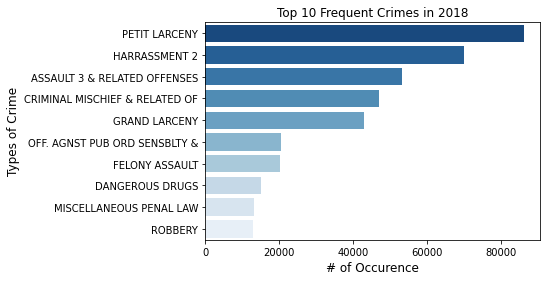

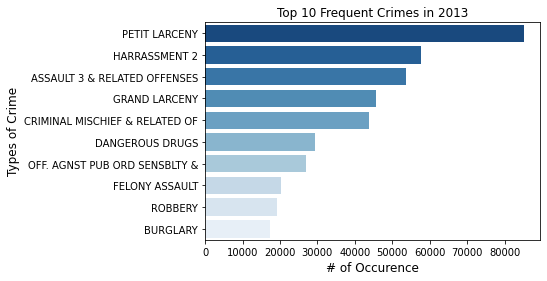

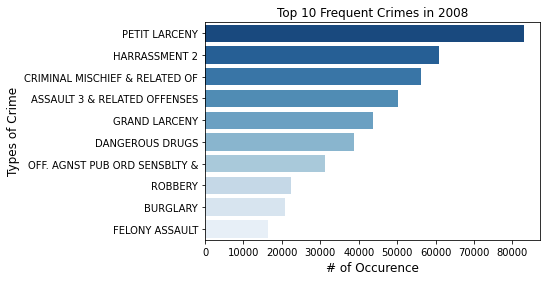

In [0]:
# What kind of crime in 2018?
ofns_desc_2018 = df[df['year'] == 2018]['OFNS_DESC'].value_counts()
plt.figure()
sns.barplot(ofns_desc_2018[:10].values, ofns_desc_2018[:10].index,
            palette=sns.color_palette("Blues_r",10))
plt.title('Top 10 Frequent Crimes in 2018')
plt.ylabel('Types of Crime', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()
# What kind of offence in 2013?
ofns_desc_2013 = df[df['year'] == 2013]['OFNS_DESC'].value_counts()
plt.figure()
sns.barplot(ofns_desc_2013[:10].values, ofns_desc_2013[:10].index,
            palette=sns.color_palette("Blues_r",10))
plt.title('Top 10 Frequent Crimes in 2013')
plt.ylabel('Types of Crime', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()
# What kind of offence in 2008?
ofns_desc_2008 = df[df['year'] == 2008]['OFNS_DESC'].value_counts()
plt.figure()
sns.barplot(ofns_desc_2008[:10].values, ofns_desc_2008[:10].index,
            palette=sns.color_palette("Blues_r",10))
plt.title('Top 10 Frequent Crimes in 2008')
plt.ylabel('Types of Crime', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()

In [0]:
dif_drug = ofns_desc_2008['DANGEROUS DRUGS'] - ofns_desc_2018['DANGEROUS DRUGS']
dif_felony = ofns_desc_2008['FELONY ASSAULT'] - ofns_desc_2018['FELONY ASSAULT']
print(f'difference in drug: {dif_drug}, difference in felony: {dif_felony}')

difference in drug: 23427, difference in felony: -3962


## Suspect's Characteristics

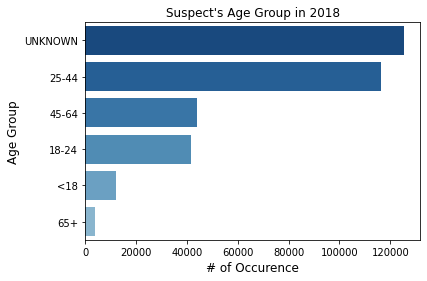

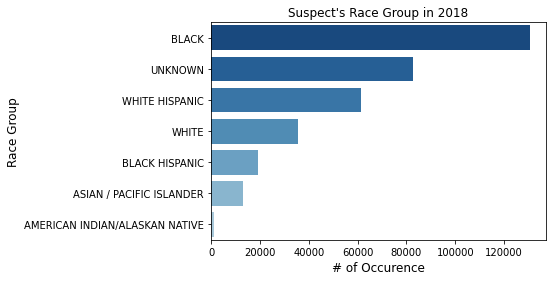

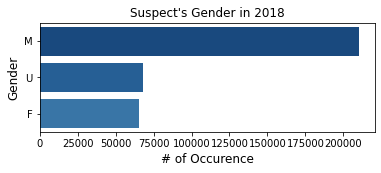

In [0]:
# AGE
sus_age_2018 = df[df['year'] == 2018]['SUSP_AGE_GROUP'].value_counts()
plt.figure()
sns.barplot(sus_age_2018[:6].values, sus_age_2018[:6].index,
            palette=sns.color_palette("Blues_r",10))
plt.title("Suspect's Age Group in 2018")
plt.ylabel('Age Group', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()
# RACE
sus_race_2018 = df[df['year'] == 2018]['SUSP_RACE'].value_counts()
plt.figure()
sns.barplot(sus_race_2018.values, sus_race_2018.index,
            palette=sns.color_palette("Blues_r",10))
plt.title("Suspect's Race Group in 2018")
plt.ylabel('Race Group', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()
# SEX
sus_sex_2018 = df[df['year'] == 2018]['SUSP_SEX'].value_counts()
plt.figure(figsize=(6,2))
sns.barplot(sus_sex_2018.values, sus_sex_2018.index,
            palette=sns.color_palette("Blues_r",10))
plt.title("Suspect's Gender in 2018")
plt.ylabel('Gender', fontsize=12)
plt.xlabel('# of Occurence', fontsize=12)
plt.show()

## Geographic Visualization

In [0]:
# Load Shapefile
df_sh = gpd.read_file(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/Neighborhood_Tabulation_Areas_Shapefile/nynta_19a/nynta.shp')
# I changed the name of dataframe with NTA
df_with_nta_2017 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2017.csv')

### Heatmap of Count of Crimes by NTAs

In [0]:
df_2017_sum = df_with_nta_2017.groupby('NTACode').count()['CMPLNT_NUM']
df_2017_sum = pd.DataFrame(df_2017_sum)
df_2017_sum.head()

,CMPLNT_NUM
NTACode,
BK09,933
BK17,2577
BK19,1267
BK21,2785
BK23,891


In [0]:
merged_2017 = df_sh.set_index('NTACode').join(df_2017_sum)
merged_2017 = merged_2017.reset_index()
merged_2017 = merged_2017.fillna(0)
merged_2017.head()

,NTACode,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area,geometry,CMPLNT_NUM
0,BK88,3,Brooklyn,047,Borough Park,39247.228028,5.400502e+07,"POLYGON ((990897.900 169268.121, 990588.252 16...",2082
1,QN51,4,Queens,081,Murray Hill,33266.904995,5.248828e+07,"POLYGON ((1038593.459 221913.355, 1039369.281 ...",1075
2,QN27,4,Queens,081,East Elmhurst,19816.712318,1.972685e+07,"POLYGON ((1022728.275 217530.808, 1023052.644 ...",1056
3,QN07,4,Queens,081,Hollis,20976.335574,2.288777e+07,"POLYGON ((1051539.660 201007.013, 1051920.726 ...",874
4,MN06,1,Manhattan,061,Manhattanville,17040.685413,1.064708e+07,"POLYGON ((999174.261 238490.105, 999084.570 23...",1736


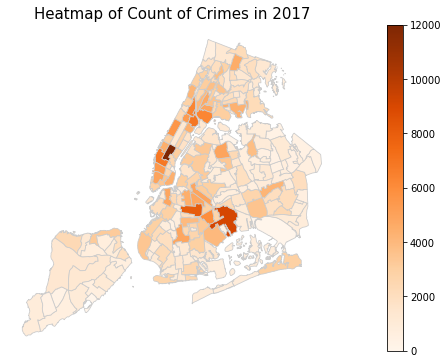

In [0]:
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of Count of Crimes in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Oranges'
vmin, vmax = 0, 12000
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)

merged_2017.plot('CMPLNT_NUM', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

### Interactive Map

In [0]:
df2 = df.loc[df['year']==2008].loc[df['month']==1]
latitude = 40.7128
longitude = -73.8960

df3 = df2.iloc[0:, [6, 14, 15]].dropna()
data = df3.iloc[0:, :]

nyc_map = folium.Map(location = [latitude, longitude], zoom_start = 11.5)
incidents = plugins.MarkerCluster().add_to(nyc_map)


for lat, lng, label, in zip(data.Latitude, data.Longitude, data.LAW_CAT_CD):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(incidents)


nyc_map.add_child(incidents)
nyc_map

In [0]:
nyc_map = folium.Map(location = [latitude, longitude], zoom_start = 11.5)
url = 'https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/new-york-city-boroughs.geojson'
nyc_geo = f'{url}'
nyc_map = folium.Map(location=[40.7128, -73.8960], zoom_start=11.5)
folium.GeoJson(
    nyc_geo,
    style_function=lambda feature: {
        'fillColor': '#ffff00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }
).add_to(nyc_map)

heatdata = data[['Latitude','Longitude']].values.tolist()

HeatMap(heatdata).add_to(nyc_map)

nyc_map

In [0]:
disdata = pd.DataFrame(df2['BORO_NM'].value_counts())
disdata.reset_index(inplace=True)
disdata.rename(columns={'index':'Neighborhood','BORO_NM':'Count'},inplace=True)

m = folium.Map(location=[40.7128, -73.8960], zoom_start=11.5)
folium.Choropleth(
    geo_data=nyc_geo,
    data=disdata,
    columns=['Neighborhood','Count'],
    key_on='feature.properties.name',
    fill_color='YlOrBr',
    fill_opacity=0.7,
    line_opacity=0.2,
    highlight=True,
    legend_name='Crime Counts in NYC'
).add_to(m)
m

### Demographic Characteristics of NTAs

In [0]:
merged_nta = df_sh.set_index('NTACode').join(
    df_nta[df_nta['year'] == 2017].set_index('GeoID')[['hispanicP','whiteP',
                                                       'blackP','asiaP',
                                                       'unemployedP',
                                                       'not_insP','povfamilyP']])
merged_nta = merged_nta.reset_index()
merged_nta = merged_nta.fillna(0)
merged_nta.columns

Index(['NTACode', 'BoroCode', 'BoroName', 'CountyFIPS', 'NTAName',
       'Shape_Leng', 'Shape_Area', 'geometry', 'hispanicP', 'whiteP', 'blackP',
       'asiaP', 'unemployedP', 'not_insP', 'povfamilyP'],
      dtype='object')

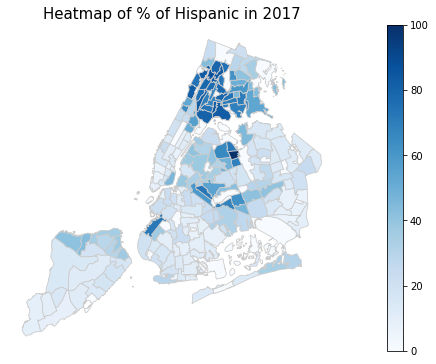

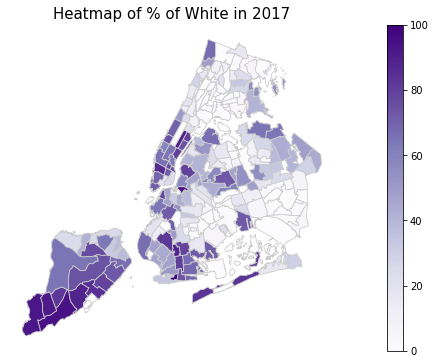

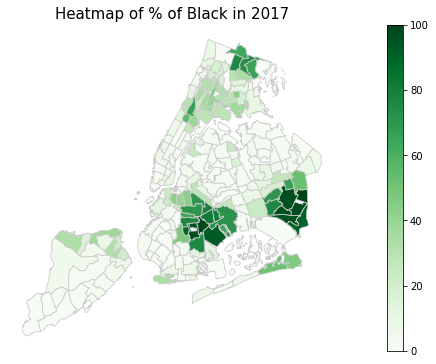

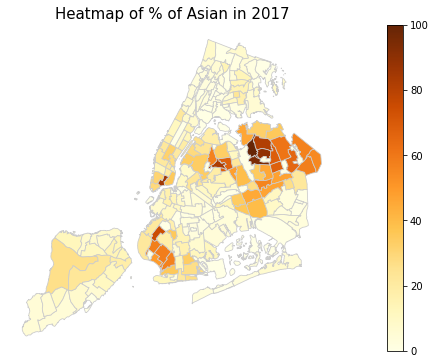

In [0]:
# Race : Hispanic
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Hispanic in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Blues'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('hispanicP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()
# Race : White
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of White in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Purples'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('whiteP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()
# Race : Black
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Black in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Greens'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('blackP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()
# Race : Asian
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Asian in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'YlOrBr'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('asiaP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

### Economic Characteristics of NTAs

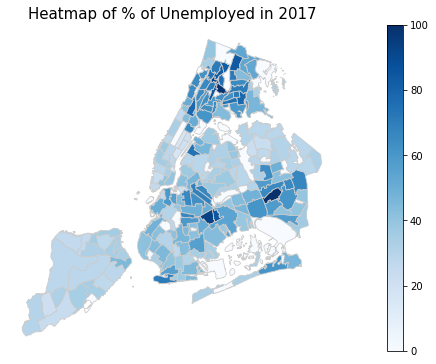

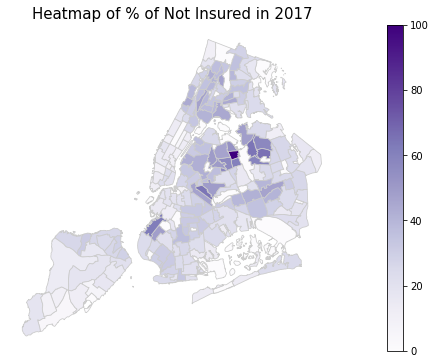

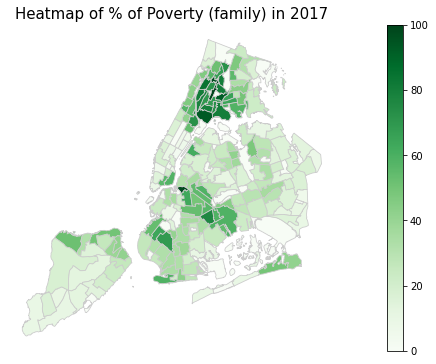

In [0]:
# Economic : Unemployed
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Unemployed in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Blues'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('unemployedP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()
# Economic : Not Insured
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Not Insured in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Purples'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('not_insP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()
# Economic : Not Insured
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of % of Poverty (family) in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Greens'
vmin, vmax = 0, 100
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)
merged_nta.plot('povfamilyP', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

# Model Building

## Data preparation for model

Cleaned dataset is alreadly available as csv file. *Do not rerun this section!*

In [0]:
df_nta.head()

,year,GeoID,Borough,PUMA,PopE,MaleE,MaleP,FemE,FemP,hispanicE,hispanicP,whiteE,whiteP,blackE,blackP,asiaE,asiaP,PopUnder15E,PopUnder15P,Pop15to34E,Pop15to34P,Pop35to54E,Pop35to54P,Pop55to74E,Pop55to74P,PopOver75E,PopOver75P,otherRaceE,otherRaceP,employedE,employedP,unemployedE,unemployedP,midincome,not_insE,not_insP,povfamilyE,povfamilyP,povchildE,povchildP,pov65E,pov65P
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,Brooklyn,4004,23945.0,11834.0,49.4,12111.0,50.6,1866.0,7.8,18242.0,76.2,1171.0,4.9,1607.0,6.7,2900.0,12.1,8173.0,34.1,7141.0,29.9,4239.0,17.8,1492.0,6.2,1059.0,4.5,13770.0,65.8,985.0,4.7,105126.0,1536.0,6.4,132.0,2.8,160.0,4.9,271.0,8.8
2013_BK17,2013,BK17,Brooklyn,4016,63033.0,28915.0,45.9,34118.0,54.1,4562.0,7.2,44000.0,69.8,3888.0,6.2,10015.0,15.9,9868.0,15.6,14341.0,22.8,17936.0,28.5,14923.0,23.7,5965.0,9.5,568.0,1.0,27126.0,51.6,2832.0,5.4,50721.0,4450.0,7.1,2271.0,13.5,2631.0,22.2,2528.0,21.6
2013_BK19,2013,BK19,Brooklyn,4018,32442.0,15228.0,46.9,17214.0,53.1,4334.0,13.4,22463.0,69.2,419.0,1.3,4413.0,13.6,4683.0,14.4,7960.0,24.5,8288.0,25.6,7377.0,22.7,4134.0,12.7,813.0,2.5,13258.0,48.4,1146.0,4.2,29690.0,4268.0,13.2,1598.0,20.1,1600.0,28.7,3003.0,42.9
2013_BK21,2013,BK21,Brooklyn,4018,28748.0,13178.0,45.8,15570.0,54.2,6108.0,21.2,8668.0,30.2,9798.0,34.1,3732.0,13.0,4844.0,16.8,7636.0,26.5,6693.0,23.2,6464.0,22.5,3111.0,10.8,442.0,1.6,8797.0,37.5,2403.0,10.2,23324.0,2525.0,9.0,1880.0,28.0,2851.0,45.7,2515.0,45.0
2013_BK23,2013,BK23,Brooklyn,4018,15309.0,6253.0,40.8,9056.0,59.2,121.0,0.8,14894.0,97.3,163.0,1.1,102.0,0.7,1252.0,8.1,2161.0,14.1,3677.0,24.0,5334.0,34.9,2885.0,18.8,29.0,0.2,6581.0,46.9,609.0,4.3,40285.0,1120.0,7.3,355.0,8.2,46.0,3.3,1253.0,22.9


In [0]:
df_2017 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2017.csv')
df_2016 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2016.csv')
df_2015 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2015.csv')
df_2014 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2014.csv')
df_2013 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2013.csv')
df_2012 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2012.csv')

In [0]:
df_2012_17 = pd.concat([df_2012,df_2013,df_2014,df_2015,df_2016,df_2017])

# # Check if the new dataframe 'df_2012_17' contains all the points from the original dataframe
# df_2012_17
# df.query('year in [2012,2013,2014,2015,2016,2017]')

In [0]:
# Drop rows without NTA code
df_2012_17_na = df_2012_17.dropna(subset=['NTACode'])

In [0]:
# Again, note that there are 7 NTAs we must exclude from our analysis.
# They are parks, prisons, etc.
special_ntas = ['BX99', 'BX98', 'BK99', 'MN99', 'QN99', 'SI99', 'QN98']
df_2012_17_na = df_2012_17_na[~df_2012_17_na.NTACode.isin(special_ntas)]

In [0]:
# Assign Index "year-NTAcode-month" e.g. 2015-BX50-12
df_2012_17_na['index']=df_2012_17_na['year'].astype(str) + '_' + df_2012_17_na['NTACode'] + '-' + df_2012_17_na['month'].astype(str)

In [0]:
# Count # of crimes by NTA by month
df_num_crime = df_2012_17_na.groupby('index').count()['CMPLNT_NUM']
df_num_crime = pd.DataFrame(df_num_crime)
df_num_crime = df_num_crime.reset_index()
df_num_crime = df_num_crime.rename(columns={'CMPLNT_NUM':'num_crimes'})
df_num_crime.head()

,index,num_crimes
0,2012_BK09-1,73
1,2012_BK09-10,86
2,2012_BK09-11,71
3,2012_BK09-12,61
4,2012_BK09-2,60


In [0]:
# Adding columns for sorting
df_num_crime['year']=df_num_crime['index'].str[0:4].astype(int)
df_num_crime['month']=df_num_crime['index'].str[10:].astype(int)
df_num_crime['nta_index'] = df_num_crime['index'].str[:9]
df_num_crime['NTACode'] = df_num_crime['index'].str[5:9]
df_num_crime.head()

,index,num_crimes,year,month,nta_index,NTACode
0,2012_BK09-1,73,2012,1,2012_BK09,BK09
1,2012_BK09-10,86,2012,10,2012_BK09,BK09
2,2012_BK09-11,71,2012,11,2012_BK09,BK09
3,2012_BK09-12,61,2012,12,2012_BK09,BK09
4,2012_BK09-2,60,2012,2,2012_BK09,BK09


In [0]:
# Sort by NTA, year, month
df_num_crime = df_num_crime.sort_values(['NTACode','year','month']) # Sort
df_num_crime.set_index('index', inplace=True)

In [0]:
# Compute 6-month moving average *excluding current month*
avg_series = df_num_crime['num_crimes'].rolling(window=6).mean().shift(1)
df_num_mean_crime = pd.merge(df_num_crime, avg_series.rename('avg6mon'), on=['index'])
df_num_mean_crime

,num_crimes,year,month,nta_index,NTACode,avg6mon
index,,,,,,
2012_BK09-1,73,2012,1,2012_BK09,BK09,NaN
2012_BK09-2,60,2012,2,2012_BK09,BK09,NaN
2012_BK09-3,45,2012,3,2012_BK09,BK09,NaN
2012_BK09-4,46,2012,4,2012_BK09,BK09,NaN
2012_BK09-5,66,2012,5,2012_BK09,BK09,NaN
...,...,...,...,...,...,...
2017_SI54-8,90,2017,8,2017_SI54,SI54,79.333333
2017_SI54-9,91,2017,9,2017_SI54,SI54,84.333333
2017_SI54-10,111,2017,10,2017_SI54,SI54,85.166667


In [0]:
# NTA_table = df_nta['GeoID'].unique()
# NTA_table

In [0]:
# Compute average # of crimes in the past 6 months
# df_num_mean_crime = df_num_crime[df_num_crime['NTACode']== NTA_table[0]].sort_values(['year','month']).reset_index()
# df_num_mean_crime['6month_mean'] = df_num_crime['num_crimes'].rolling(window=6).mean()
# df_num_mean_crime.drop(columns=['level_0'],inplace=True)
# for i in range(1,len(NTA_table)):
#   temp = df_num_crime[df_num_crime['NTACode']== NTA_table[i]].sort_values(['year','month']).reset_index()
#   temp['6month_mean'] = df_num_mean_crime['num_crimes'].rolling(window=6).mean()
#   temp.drop(columns=['level_0'],inplace=True)
#   df_num_mean_crime = pd.concat([df_num_mean_crime, temp], ignore_index=True)
# del temp
# df_num_mean_crime.head(50)

In [0]:
# merge this with the df_nta
df_num_mean_crime = df_num_mean_crime[df_num_mean_crime['year']>2012]
df_model = df_num_mean_crime.join(df_nta[['PopE','MaleP', 'FemP', 'hispanicP', 'whiteP',
       'blackP', 'asiaP', 'PopUnder15P', 'Pop15to34P', 'Pop35to54P','Pop55to74P','PopOver75P','otherRaceP','employedP', 
       'unemployedP', 'midincome','not_insP', 'povfamilyP', 'povchildP', 'pov65P']], on='nta_index')
df_model
df_model = df_model.reset_index()
df_model.head()

,index,num_crimes,year,month,nta_index,NTACode,avg6mon,PopE,MaleP,FemP,hispanicP,whiteP,blackP,asiaP,PopUnder15P,Pop15to34P,Pop35to54P,Pop55to74P,PopOver75P,otherRaceP,employedP,unemployedP,midincome,not_insP,povfamilyP,povchildP,pov65P
0,2013_BK09-1,62,2013,1,2013_BK09,BK09,77.333333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
1,2013_BK09-2,72,2013,2,2013_BK09,BK09,75.166667,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
2,2013_BK09-3,67,2013,3,2013_BK09,BK09,71.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
3,2013_BK09-4,72,2013,4,2013_BK09,BK09,69.833333,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8
4,2013_BK09-5,69,2013,5,2013_BK09,BK09,67.500000,23945.0,49.4,50.6,7.8,76.2,4.9,6.7,12.1,34.1,29.9,17.8,6.2,4.5,65.8,4.7,105126.0,6.4,2.8,4.9,8.8


In [0]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11280 entries, 0 to 11279
Data columns (total 27 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        11280 non-null  object 
 1   num_crimes   11280 non-null  int64  
 2   year         11280 non-null  int64  
 3   month        11280 non-null  int64  
 4   nta_index    11280 non-null  object 
 5   NTACode      11280 non-null  object 
 6   avg6mon      11280 non-null  float64
 7   PopE         11280 non-null  float64
 8   MaleP        11280 non-null  float64
 9   FemP         11280 non-null  float64
 10  hispanicP    11280 non-null  float64
 11  whiteP       11280 non-null  float64
 12  blackP       11280 non-null  float64
 13  asiaP        11280 non-null  float64
 14  PopUnder15P  11280 non-null  float64
 15  Pop15to34P   11280 non-null  float64
 16  Pop35to54P   11280 non-null  float64
 17  Pop55to74P   11280 non-null  float64
 18  PopOver75P   11280 non-null  float64
 19  othe

In [0]:
# Exporting this dataset for model building
df_model.to_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_dataset.csv', index = False, header=True)

# Prediction on the Rate of Change

In [0]:
df_2017 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2017.csv')
df_2016 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2016.csv')
df_2015 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2015.csv')
df_2014 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2014.csv')
df_2013 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2013.csv')
df_2012 = pd.read_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/cleaned_dataset_2012.csv')
df_2012_17 = pd.concat([df_2012,df_2013,df_2014,df_2015,df_2016,df_2017])
df_2012_17_na = df_2012_17.dropna(subset=['NTACode'])

In [0]:
# Again, note that there are 7 NTAs we must exclude from our analysis.
# They are parks, prisons, etc.
special_ntas = ['BX99', 'BX98', 'BK99', 'MN99', 'QN99', 'SI99', 'QN98']
df_2012_17_na = df_2012_17_na[~df_2012_17_na.NTACode.isin(special_ntas)]

In [0]:
# Assign Index "year-NTAcode-month" e.g. 2015-BX50-12
df_2012_17_na['index']=df_2012_17_na['year'].astype(str) + '_' + df_2012_17_na['NTACode'] + '-' + df_2012_17_na['month'].astype(str)

In [15]:
# Count # of crimes by NTA by month
df_num_crime = df_2012_17_na.groupby('index').count()['CMPLNT_NUM']
df_num_crime = pd.DataFrame(df_num_crime)
df_num_crime = df_num_crime.reset_index()
df_num_crime = df_num_crime.rename(columns={'CMPLNT_NUM':'num_crimes'})
df_num_crime.head()

,index,num_crimes
0,2012_BK09-1,73
1,2012_BK09-10,86
2,2012_BK09-11,71
3,2012_BK09-12,61
4,2012_BK09-2,60


In [16]:
# Adding columns for sorting
df_num_crime['year']=df_num_crime['index'].str[0:4].astype(int)
df_num_crime['month']=df_num_crime['index'].str[10:].astype(int)
df_num_crime['nta_index'] = df_num_crime['index'].str[:9]
df_num_crime['NTACode'] = df_num_crime['index'].str[5:9]
df_num_crime.head()

,index,num_crimes,year,month,nta_index,NTACode
0,2012_BK09-1,73,2012,1,2012_BK09,BK09
1,2012_BK09-10,86,2012,10,2012_BK09,BK09
2,2012_BK09-11,71,2012,11,2012_BK09,BK09
3,2012_BK09-12,61,2012,12,2012_BK09,BK09
4,2012_BK09-2,60,2012,2,2012_BK09,BK09


In [0]:
# Sort by NTA, year, month
df_num_crime = df_num_crime.sort_values(['NTACode','year','month']) # Sort
df_num_crime.set_index('index', inplace=True)

In [18]:
# Considering using crime type 
df_2012_17_na.PREM_TYP_DESC.value_counts()

STREET                        888120
RESIDENCE - APT. HOUSE        627869
RESIDENCE-HOUSE               270018
RESIDENCE - PUBLIC HOUSING    226606
COMMERCIAL BUILDING            75059
                               ...  
PHOTO/COPY                       370
CEMETERY                         199
LOAN COMPANY                     161
TRAMWAY                           63
MAILBOX INSIDE                    50
Name: PREM_TYP_DESC, Length: 72, dtype: int64

In [19]:
# Count # of crimes by NTA by month
df_num_kind = df_2012_17_na.groupby(['index','LAW_CAT_CD']).count()['CMPLNT_NUM']
df_num_kind = pd.DataFrame(df_num_kind)
df_num_kind = df_num_kind.reset_index()
df_num_kind = df_num_kind.rename(columns={'CMPLNT_NUM':'num_kind'})
df_num_kind.head()

,index,LAW_CAT_CD,num_kind
0,2012_BK09-1,FELONY,23
1,2012_BK09-1,MISDEMEANOR,45
2,2012_BK09-1,VIOLATION,5
3,2012_BK09-10,FELONY,41
4,2012_BK09-10,MISDEMEANOR,41


In [0]:
df_felony = df_num_kind[df_num_kind['LAW_CAT_CD']=='FELONY'][['index','num_kind']]
df_felony.rename(columns={'num_kind': 'num_felony'},inplace=True)
df_misdemeanor = df_num_kind[df_num_kind['LAW_CAT_CD']=='MISDEMEANOR'][['index','num_kind']]
df_misdemeanor.rename(columns={'num_kind': 'num_misdemeanor'},inplace=True)
df_violation = df_num_kind[df_num_kind['LAW_CAT_CD']=='VIOLATION'][['index','num_kind']]
df_violation.rename(columns={'num_kind': 'num_violation'},inplace=True)

In [21]:
df_time = df_num_crime.join(df_felony.set_index('index')['num_felony'])
df_time = df_time.join(df_misdemeanor.set_index('index')['num_misdemeanor'])
df_time = df_time.join(df_violation.set_index('index')['num_violation'])
df_time.head()

,num_crimes,year,month,nta_index,NTACode,num_felony,num_misdemeanor,num_violation
index,,,,,,,,
2012_BK09-1,73,2012,1,2012_BK09,BK09,23,45,5.0
2012_BK09-2,60,2012,2,2012_BK09,BK09,19,33,8.0
2012_BK09-3,45,2012,3,2012_BK09,BK09,14,18,13.0
2012_BK09-4,46,2012,4,2012_BK09,BK09,10,32,4.0
2012_BK09-5,66,2012,5,2012_BK09,BK09,21,36,9.0


In [0]:
df_time.to_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/data_timeseries.csv',index=False)

## mapping

In [0]:
# !pip install geopandas

     |████████████████████████████████| 931kB 2.7MB/s 
     |████████████████████████████████| 14.7MB 307kB/s 
     |████████████████████████████████| 10.4MB 31.9MB/s 


### Yearly analysis

In [0]:
df_time_year = df_time.reset_index()
df_time_year.drop(columns='index',inplace=True)
df_time_year = df_time_year[['nta_index','num_crimes','num_felony','num_misdemeanor','num_violation']].groupby(['nta_index']).sum()
df_time_year = df_time_year.reset_index()

In [24]:
# Adding columns for sorting
df_time_year['year']=df_time_year['nta_index'].str[0:4].astype(int)
df_time_year['NTACode'] = df_time_year['nta_index'].str[5:9]
# Sort by NTA, year, month
df_time_year = df_time_year.sort_values(['NTACode','year']) # Sort
# df_time_year.set_index('index', inplace=True)
df_time_year.head()

,nta_index,num_crimes,num_felony,num_misdemeanor,num_violation,year,NTACode
0,2012_BK09,839,270,478,91.0,2012,BK09
188,2013_BK09,865,253,520,92.0,2013,BK09
376,2014_BK09,896,244,524,128.0,2014,BK09
564,2015_BK09,989,301,580,108.0,2015,BK09
752,2016_BK09,1054,282,636,136.0,2016,BK09


In [0]:
df_time_year = df_time_year.set_index('nta_index')

In [0]:
df_diff = df_time_year[['num_crimes','num_felony','num_misdemeanor','num_violation']].pct_change()

In [27]:
df_diff.rename(columns = {'num_crimes':'diff_crimes', 'num_felony':'diff_felony',
                'num_misdemeanor':'diff_misdemeanor','num_violation':'diff_violation'},inplace=True)
df_diff.head()

,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
nta_index,,,,
2012_BK09,NaN,NaN,NaN,NaN
2013_BK09,0.030989,-0.062963,0.087866,0.010989
2014_BK09,0.035838,-0.035573,0.007692,0.391304
2015_BK09,0.103795,0.233607,0.106870,-0.156250
2016_BK09,0.065723,-0.063123,0.096552,0.259259


In [28]:
df_time_year = df_time_year.join(df_diff[['diff_crimes','diff_felony','diff_misdemeanor','diff_violation']])
df_time_year.reset_index(inplace=True)
df_time_year.head()

,nta_index,num_crimes,num_felony,num_misdemeanor,num_violation,year,NTACode,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
0,2012_BK09,839,270,478,91.0,2012,BK09,NaN,NaN,NaN,NaN
1,2013_BK09,865,253,520,92.0,2013,BK09,0.030989,-0.062963,0.087866,0.010989
2,2014_BK09,896,244,524,128.0,2014,BK09,0.035838,-0.035573,0.007692,0.391304
3,2015_BK09,989,301,580,108.0,2015,BK09,0.103795,0.233607,0.106870,-0.156250
4,2016_BK09,1054,282,636,136.0,2016,BK09,0.065723,-0.063123,0.096552,0.259259


In [0]:
import geopandas as gpd
from geopandas.geoseries import *
from shapely.geometry import Point

In [0]:
# Load Shapefile
df_sh = gpd.read_file(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/Neighborhood_Tabulation_Areas_Shapefile/nynta_19a/nynta.shp')

In [0]:
df_diff_2017 = df_time_year[df_time_year['year']==2017]
df_diff_2016 = df_time_year[df_time_year['year']==2016]

In [32]:
diff_geo = df_sh.set_index('NTACode').join(df_diff_2017.set_index('NTACode')['diff_crimes'])
diff_geo = diff_geo.join(df_diff_2016.set_index('NTACode')[['diff_felony','diff_misdemeanor','diff_violation']])
diff_geo = diff_geo.reset_index()
diff_geo.head()

,NTACode,BoroCode,BoroName,CountyFIPS,NTAName,Shape_Leng,Shape_Area,geometry,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
0,BK88,3,Brooklyn,047,Borough Park,39247.228028,5.400502e+07,"POLYGON ((990897.900 169268.121, 990588.252 16...",-0.088840,-0.036620,-0.014948,-0.017361
1,QN51,4,Queens,081,Murray Hill,33266.904995,5.248828e+07,"POLYGON ((1038593.459 221913.355, 1039369.281 ...",-0.088983,0.069061,0.083333,0.589928
2,QN27,4,Queens,081,East Elmhurst,19816.712318,1.972685e+07,"POLYGON ((1022728.275 217530.808, 1023052.644 ...",0.015385,0.107143,0.048290,0.379845
3,QN07,4,Queens,081,Hollis,20976.335574,2.288777e+07,"POLYGON ((1051539.660 201007.013, 1051920.726 ...",-0.085774,0.061538,-0.089796,0.085526
4,MN06,1,Manhattan,061,Manhattanville,17040.685413,1.064708e+07,"POLYGON ((999174.261 238490.105, 999084.570 23...",-0.132434,0.002053,0.116848,0.157025


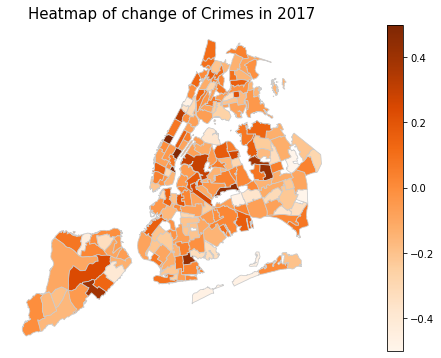

In [33]:
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of change of Crimes in 2017', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Oranges'
vmin, vmax = -0.5, 0.5
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)

diff_geo.plot('diff_crimes', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

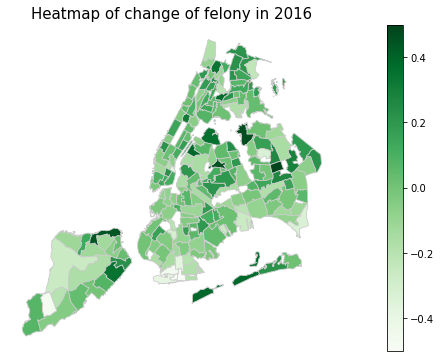

In [34]:
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of change of felony in 2016', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Greens'
vmin, vmax = -0.5, 0.5
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)

diff_geo.plot('diff_felony', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

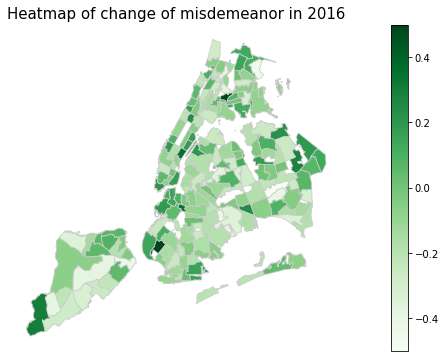

In [35]:
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of change of misdemeanor in 2016', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Greens'
vmin, vmax = -0.5, 0.5
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)

diff_geo.plot('diff_misdemeanor', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

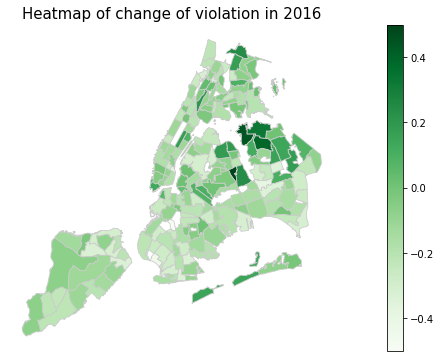

In [36]:
# setting for plot area
fig, ax = plt.subplots(1, figsize=(18, 6))
ax.axis('off')
ax.set_title('Heatmap of change of violation in 2016', fontdict={'fontsize': '15', 'fontweight' : '3'})
# setting for colorbar
color = 'Greens'
vmin, vmax = -0.5, 0.5
sm = plt.cm.ScalarMappable(cmap=color, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm)
cbar.ax.tick_params(labelsize=10)

diff_geo.plot('diff_violation', cmap=color, linewidth=0.8, ax=ax, edgecolor='0.8', figsize=(18, 6))
plt.show()

## Predicting Annual Increase Rate

In [37]:
df_year_nta = df_diff
df_year_nta.head()

,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
nta_index,,,,
2012_BK09,NaN,NaN,NaN,NaN
2013_BK09,0.030989,-0.062963,0.087866,0.010989
2014_BK09,0.035838,-0.035573,0.007692,0.391304
2015_BK09,0.103795,0.233607,0.106870,-0.156250
2016_BK09,0.065723,-0.063123,0.096552,0.259259


In [39]:
df_nta = pd.read_csv('/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/nta_character.csv', index_col=0)
df_nta = df_nta.sort_values(['GeoID','year'])
df_nta.head(10)

,year,GeoID,Borough,PUMA,PopE,MaleE,MaleP,FemE,FemP,hispanicE,hispanicP,whiteE,whiteP,blackE,blackP,asiaE,asiaP,PopUnder15E,PopUnder15P,Pop15to34E,Pop15to34P,Pop35to54E,Pop35to54P,Pop55to74E,Pop55to74P,PopOver75E,PopOver75P,otherRaceE,otherRaceP,employedE,employedP,unemployedE,unemployedP,midincome,not_insE,not_insP,povfamilyE,povfamilyP,povchildE,povchildP,pov65E,pov65P
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013_BK09,2013,BK09,Brooklyn,4004,23945.0,11834.0,49.4,12111.0,50.6,1866.0,7.8,18242.0,76.2,1171.0,4.9,1607.0,6.7,2900.0,12.1,8173.0,34.1,7141.0,29.9,4239.0,17.8,1492.0,6.2,1059.0,4.5,13770.0,65.8,985.0,4.7,105126.0,1536.0,6.4,132.0,2.8,160.0,4.9,271.0,8.8
2014_BK09,2014,BK09,Brooklyn,4004,23532.0,11534.0,49.0,11998.0,51.0,2099.0,8.9,17273.0,73.4,1351.0,5.7,1830.0,7.8,2705.0,11.5,8260.0,35.1,7019.0,29.8,4140.0,17.6,1408.0,5.9,979.0,4.2,13636.0,65.8,775.0,3.7,105398.0,1643.0,7.0,120.0,2.6,97.0,3.3,246.0,8.0
2015_BK09,2015,BK09,Brooklyn,4004,23839.0,11815.0,49.6,12024.0,50.4,1966.0,8.2,17460.0,73.2,1288.0,5.4,2108.0,8.8,2843.0,11.9,7949.0,33.3,7335.0,30.7,4328.0,18.1,1384.0,5.8,1017.0,4.2,13669.0,65.3,754.0,3.6,102850.0,1794.0,7.5,102.0,2.2,70.0,2.3,334.0,10.2
2016_BK09,2016,BK09,Brooklyn,4004,24140.0,12002.0,49.7,12138.0,50.3,1949.0,8.1,17461.0,72.3,1197.0,5.0,2327.0,9.6,2931.0,12.1,8013.0,33.2,7495.0,31.0,4221.0,17.5,1480.0,6.2,1206.0,5.0,13873.0,65.7,545.0,2.6,116189.0,1629.0,6.7,100.0,2.0,88.0,2.7,341.0,10.6
2017_BK09,2017,BK09,Brooklyn,4004,24212.0,11647.0,48.1,12565.0,51.9,1883.0,7.8,17734.0,73.2,1018.0,4.2,2337.0,9.7,3149.0,13.0,7905.0,32.7,7300.0,30.2,4294.0,17.7,1564.0,6.5,1240.0,5.0,13754.0,65.8,564.0,2.7,125817.0,1501.0,6.2,42.0,0.9,11.0,0.3,340.0,9.8
2013_BK17,2013,BK17,Brooklyn,4016,63033.0,28915.0,45.9,34118.0,54.1,4562.0,7.2,44000.0,69.8,3888.0,6.2,10015.0,15.9,9868.0,15.6,14341.0,22.8,17936.0,28.5,14923.0,23.7,5965.0,9.5,568.0,1.0,27126.0,51.6,2832.0,5.4,50721.0,4450.0,7.1,2271.0,13.5,2631.0,22.2,2528.0,21.6
2014_BK17,2014,BK17,Brooklyn,4016,63459.0,29456.0,46.4,34003.0,53.6,4522.0,7.1,44222.0,69.7,4342.0,6.8,9681.0,15.3,10144.0,16.0,14180.0,22.4,18210.0,28.7,15157.0,23.9,5768.0,9.1,692.0,1.1,27509.0,52.2,3266.0,6.2,51314.0,4576.0,7.2,2176.0,13.1,2637.0,21.9,2521.0,21.5
2015_BK17,2015,BK17,Brooklyn,4016,64254.0,30126.0,46.9,34128.0,53.1,5380.0,8.4,43478.0,67.7,4462.0,6.9,10126.0,15.8,10144.0,15.7,14723.0,22.8,17838.0,27.8,15761.0,24.5,5788.0,9.0,808.0,1.4,28445.0,53.2,3012.0,5.6,51203.0,4718.0,7.4,2132.0,12.8,2518.0,20.9,2389.0,19.5
2016_BK17,2016,BK17,Brooklyn,4016,66293.0,31519.0,47.5,34774.0,52.5,5809.0,8.8,43445.0,65.5,4741.0,7.2,11275.0,17.0,10357.0,15.6,15459.0,23.3,17973.0,27.1,16756.0,25.3,5748.0,8.7,1023.0,1.6,29706.0,53.8,3216.0,5.8,54371.0,4767.0,7.2,2304.0,13.2,2692.0,21.6,2353.0,18.7


In [40]:
df_diff_nta = df_nta[['MaleP','hispanicP','whiteP','blackP',
                       'asiaP','PopUnder15P','Pop15to34P','Pop35to54P',
                       'Pop55to74P','PopOver75P','otherRaceP','unemployedP',
                       'not_insP','povfamilyP','povchildP','pov65P']].diff().shift(1) #########Edited###########
df_diff_nta.rename(columns = {'MaleP':'diff_MaleP',
                               'hispanicP':'diff_hispanicP',
                               'whiteP':'diff_whiteP',
                               'blackP':'diff_blackP',
                               'asiaP':'diff_asiaP',
                               'PopUnder15P':'diff_PopUnder15P',
                               'Pop15to34P':'diff_Pop15to34P',
                               'Pop35to54P':'diff_Pop35to54P',
                               'Pop55to74P':'diff_Pop55to74P',
                               'PopOver75P':'diff_PopOver75P',
                               'otherRaceP':'diff_otherRaceP',
                               'unemployedP':'diff_unemployedP',
                               'not_insP':'diff_not_insP',
                               'povfamilyP':'diff_povfamilyP',
                               'povchildP':'diff_povchildP',
                               'pov65P':'diff_pov65P'},inplace=True)
df_diff_nta.head(10)

,diff_MaleP,diff_hispanicP,diff_whiteP,diff_blackP,diff_asiaP,diff_PopUnder15P,diff_Pop15to34P,diff_Pop35to54P,diff_Pop55to74P,diff_PopOver75P,diff_otherRaceP,diff_unemployedP,diff_not_insP,diff_povfamilyP,diff_povchildP,diff_pov65P
nta_index,,,,,,,,,,,,,,,,
2013_BK09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014_BK09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015_BK09,-0.4,1.1,-2.8,0.8,1.1,-0.6,1.0,-0.1,-0.2,-0.3,-0.3,-1.0,0.6,-0.2,-1.6,-0.8
2016_BK09,0.6,-0.7,-0.2,-0.3,1.0,0.4,-1.8,0.9,0.5,-0.1,0.0,-0.1,0.5,-0.4,-1.0,2.2
2017_BK09,0.1,-0.1,-0.9,-0.4,0.8,0.2,-0.1,0.3,-0.6,0.4,0.8,-1.0,-0.8,-0.2,0.4,0.4
2013_BK17,-1.6,-0.3,0.9,-0.8,0.1,0.9,-0.5,-0.8,0.2,0.3,0.0,0.1,-0.5,-1.1,-2.4,-0.8
2014_BK17,-2.2,-0.6,-3.4,2.0,6.2,2.6,-9.9,-1.7,6.0,3.0,-4.0,2.7,0.9,12.6,21.9,11.8
2015_BK17,0.5,-0.1,-0.1,0.6,-0.6,0.4,-0.4,0.2,0.2,-0.4,0.1,0.8,0.1,-0.4,-0.3,-0.1
2016_BK17,0.5,1.3,-2.0,0.1,0.5,-0.3,0.4,-0.9,0.6,-0.1,0.3,-0.6,0.2,-0.3,-1.0,-2.0


In [41]:
df_rate_nta = df_nta[['PopE','midincome']].pct_change().shift(1) #########Edited###########
df_rate_nta.rename(columns = {'PopE':'diff_PopE',
                               'midincome':'diff_midincome'},inplace=True) #########Edited###########
df_rate_nta.head(10)

,diff_PopE,diff_midincome
nta_index,,
2013_BK09,NaN,NaN
2014_BK09,NaN,NaN
2015_BK09,-0.017248,0.002587
2016_BK09,0.013046,-0.024175
2017_BK09,0.012626,0.129694
2013_BK17,0.002983,0.082865
2014_BK17,1.603378,-0.596867
2015_BK17,0.006758,0.011691
2016_BK17,0.012528,-0.002163


In [42]:
df_model_time_nta = df_time_year.set_index('nta_index').join(df_diff_nta)
df_model_time_nta = df_model_time_nta.join(df_rate_nta)
df_model_time_nta.head(10) #########Edited###########

,num_crimes,num_felony,num_misdemeanor,num_violation,year,NTACode,diff_crimes,diff_felony,diff_misdemeanor,diff_violation,diff_MaleP,diff_hispanicP,diff_whiteP,diff_blackP,diff_asiaP,diff_PopUnder15P,diff_Pop15to34P,diff_Pop35to54P,diff_Pop55to74P,diff_PopOver75P,diff_otherRaceP,diff_unemployedP,diff_not_insP,diff_povfamilyP,diff_povchildP,diff_pov65P,diff_PopE,diff_midincome
nta_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012_BK09,839,270,478,91.0,2012,BK09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013_BK09,865,253,520,92.0,2013,BK09,0.030989,-0.062963,0.087866,0.010989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014_BK09,896,244,524,128.0,2014,BK09,0.035838,-0.035573,0.007692,0.391304,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015_BK09,989,301,580,108.0,2015,BK09,0.103795,0.233607,0.106870,-0.156250,-0.4,1.1,-2.8,0.8,1.1,-0.6,1.0,-0.1,-0.2,-0.3,-0.3,-1.0,0.6,-0.2,-1.6,-0.8,-0.017248,0.002587
2016_BK09,1054,282,636,136.0,2016,BK09,0.065723,-0.063123,0.096552,0.259259,0.6,-0.7,-0.2,-0.3,1.0,0.4,-1.8,0.9,0.5,-0.1,0.0,-0.1,0.5,-0.4,-1.0,2.2,0.013046,-0.024175
2017_BK09,933,303,495,135.0,2017,BK09,-0.114801,0.074468,-0.221698,-0.007353,0.1,-0.1,-0.9,-0.4,0.8,0.2,-0.1,0.3,-0.6,0.4,0.8,-1.0,-0.8,-0.2,0.4,0.4,0.012626,0.129694
2012_BK17,2932,932,1630,370.0,2012,BK17,2.142551,2.075908,2.292929,1.740741,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013_BK17,2669,1008,1347,314.0,2013,BK17,-0.089700,0.081545,-0.173620,-0.151351,-1.6,-0.3,0.9,-0.8,0.1,0.9,-0.5,-0.8,0.2,0.3,0.0,0.1,-0.5,-1.1,-2.4,-0.8,0.002983,0.082865
2014_BK17,2714,970,1407,337.0,2014,BK17,0.016860,-0.037698,0.044543,0.073248,-2.2,-0.6,-3.4,2.0,6.2,2.6,-9.9,-1.7,6.0,3.0,-4.0,2.7,0.9,12.6,21.9,11.8,1.603378,-0.596867


In [43]:
#########Edited###########
shifted_diff_category = df_model_time_nta[['diff_felony','diff_misdemeanor','diff_violation']].shift(1)
df_model_time_nta = df_model_time_nta[['num_crimes','num_felony','num_misdemeanor',
                                       'num_violation','year','NTACode','diff_crimes',
                                       'diff_MaleP','diff_hispanicP','diff_whiteP',
                                       'diff_blackP','diff_asiaP','diff_PopUnder15P',
                                       'diff_Pop15to34P','diff_Pop35to54P','diff_Pop55to74P',
                                       'diff_PopOver75P','diff_otherRaceP','diff_unemployedP',
                                       'diff_not_insP','diff_PopE','diff_midincome',
                                       'diff_povfamilyP','diff_povchildP','diff_pov65P']].join(shifted_diff_category)
df_model_time_nta.reset_index(inplace=True)
df_model_time_nta.head(10)
#########Edited###########

,nta_index,num_crimes,num_felony,num_misdemeanor,num_violation,year,NTACode,diff_crimes,diff_MaleP,diff_hispanicP,diff_whiteP,diff_blackP,diff_asiaP,diff_PopUnder15P,diff_Pop15to34P,diff_Pop35to54P,diff_Pop55to74P,diff_PopOver75P,diff_otherRaceP,diff_unemployedP,diff_not_insP,diff_PopE,diff_midincome,diff_povfamilyP,diff_povchildP,diff_pov65P,diff_felony,diff_misdemeanor,diff_violation
0,2012_BK09,839,270,478,91.0,2012,BK09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013_BK09,865,253,520,92.0,2013,BK09,0.030989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2014_BK09,896,244,524,128.0,2014,BK09,0.035838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.062963,0.087866,0.010989
3,2015_BK09,989,301,580,108.0,2015,BK09,0.103795,-0.4,1.1,-2.8,0.8,1.1,-0.6,1.0,-0.1,-0.2,-0.3,-0.3,-1.0,0.6,-0.017248,0.002587,-0.2,-1.6,-0.8,-0.035573,0.007692,0.391304
4,2016_BK09,1054,282,636,136.0,2016,BK09,0.065723,0.6,-0.7,-0.2,-0.3,1.0,0.4,-1.8,0.9,0.5,-0.1,0.0,-0.1,0.5,0.013046,-0.024175,-0.4,-1.0,2.2,0.233607,0.106870,-0.156250
5,2017_BK09,933,303,495,135.0,2017,BK09,-0.114801,0.1,-0.1,-0.9,-0.4,0.8,0.2,-0.1,0.3,-0.6,0.4,0.8,-1.0,-0.8,0.012626,0.129694,-0.2,0.4,0.4,-0.063123,0.096552,0.259259
6,2012_BK17,2932,932,1630,370.0,2012,BK17,2.142551,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.074468,-0.221698,-0.007353
7,2013_BK17,2669,1008,1347,314.0,2013,BK17,-0.089700,-1.6,-0.3,0.9,-0.8,0.1,0.9,-0.5,-0.8,0.2,0.3,0.0,0.1,-0.5,0.002983,0.082865,-1.1,-2.4,-0.8,2.075908,2.292929,1.740741
8,2014_BK17,2714,970,1407,337.0,2014,BK17,0.016860,-2.2,-0.6,-3.4,2.0,6.2,2.6,-9.9,-1.7,6.0,3.0,-4.0,2.7,0.9,1.603378,-0.596867,12.6,21.9,11.8,0.081545,-0.173620,-0.151351
9,2015_BK17,2487,889,1285,313.0,2015,BK17,-0.083640,0.5,-0.1,-0.1,0.6,-0.6,0.4,-0.4,0.2,0.2,-0.4,0.1,0.8,0.1,0.006758,0.011691,-0.4,-0.3,-0.1,-0.037698,0.044543,0.073248


In [0]:
df_model_time_nta = df_model_time_nta[df_model_time_nta['year']>2014]
df_model_time_nta.drop(columns=['nta_index','num_crimes','num_felony',
                                'num_misdemeanor','num_violation','year','NTACode'],inplace=True) #########Edited###########

In [45]:
df_model_time_nta.head(10)

,diff_crimes,diff_MaleP,diff_hispanicP,diff_whiteP,diff_blackP,diff_asiaP,diff_PopUnder15P,diff_Pop15to34P,diff_Pop35to54P,diff_Pop55to74P,diff_PopOver75P,diff_otherRaceP,diff_unemployedP,diff_not_insP,diff_PopE,diff_midincome,diff_povfamilyP,diff_povchildP,diff_pov65P,diff_felony,diff_misdemeanor,diff_violation
3,0.103795,-0.4,1.1,-2.8,0.8,1.1,-0.6,1.0,-0.1,-0.2,-0.3,-0.3,-1.0,0.6,-0.017248,0.002587,-0.2,-1.6,-0.8,-0.035573,0.007692,0.391304
4,0.065723,0.6,-0.7,-0.2,-0.3,1.0,0.4,-1.8,0.9,0.5,-0.1,0.0,-0.1,0.5,0.013046,-0.024175,-0.4,-1.0,2.2,0.233607,0.106870,-0.156250
5,-0.114801,0.1,-0.1,-0.9,-0.4,0.8,0.2,-0.1,0.3,-0.6,0.4,0.8,-1.0,-0.8,0.012626,0.129694,-0.2,0.4,0.4,-0.063123,0.096552,0.259259
9,-0.083640,0.5,-0.1,-0.1,0.6,-0.6,0.4,-0.4,0.2,0.2,-0.4,0.1,0.8,0.1,0.006758,0.011691,-0.4,-0.3,-0.1,-0.037698,0.044543,0.073248
10,0.030961,0.5,1.3,-2.0,0.1,0.5,-0.3,0.4,-0.9,0.6,-0.1,0.3,-0.6,0.2,0.012528,-0.002163,-0.3,-1.0,-2.0,-0.083505,-0.086709,-0.071217
11,0.005070,0.6,0.4,-2.2,0.3,1.2,-0.1,0.5,-0.7,0.8,-0.3,0.2,0.2,-0.2,0.031733,0.061871,0.4,0.7,-0.8,-0.109111,0.113619,0.089457
15,0.000698,0.0,-1.0,-0.5,0.0,1.6,0.7,-0.9,-0.7,1.2,-0.2,-0.2,0.0,-1.2,0.021700,0.039811,0.5,1.9,1.8,0.060738,-0.092707,0.236686
16,-0.089323,0.3,-0.3,1.7,-0.3,-0.9,0.5,-1.2,0.9,-0.6,0.2,0.0,0.3,-0.4,0.008357,0.099184,-0.6,-0.3,0.0,-0.047035,0.016349,0.057416
17,-0.029119,0.3,-0.7,-0.9,-0.2,0.6,0.3,0.2,0.0,-1.4,1.2,1.0,-0.3,-0.5,0.021961,0.052013,0.1,0.0,-1.2,-0.276824,0.046917,-0.153846
21,0.048254,1.1,3.7,1.8,-4.3,-1.4,1.1,0.5,0.8,-1.1,-1.0,0.2,-0.3,-0.1,0.016732,-0.004073,2.5,-2.6,2.6,0.028369,-0.020874,0.237805


In [46]:
df_model_time_nta.describe()

,diff_crimes,diff_MaleP,diff_hispanicP,diff_whiteP,diff_blackP,diff_asiaP,diff_PopUnder15P,diff_Pop15to34P,diff_Pop35to54P,diff_Pop55to74P,diff_PopOver75P,diff_otherRaceP,diff_unemployedP,diff_not_insP,diff_PopE,diff_midincome,diff_povfamilyP,diff_povchildP,diff_pov65P,diff_felony,diff_misdemeanor,diff_violation
count,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.000000,564.00000,564.000000,5.640000e+02,564.00000,564.000000,564.000000,564.000000,564.000000,564.000000,562.000000,564.000000,564.000000,564.000000,564.000000
mean,-0.014642,0.028723,0.134397,-0.318794,-0.154787,0.236170,-0.047872,-0.141667,-0.17766,0.343262,2.801418e-02,0.10461,-0.436348,-0.964007,0.007863,0.019942,-0.098050,-0.099644,0.143794,-0.006173,-0.020210,0.055082
std,0.074731,0.757760,1.350017,1.198431,1.084770,0.865833,0.735798,0.864425,0.74036,0.767877,3.945845e-01,0.47791,0.598733,0.970890,0.021267,0.037742,1.277589,2.396455,2.097731,0.097879,0.090023,0.165218
min,-0.226300,-3.600000,-6.500000,-5.700000,-4.800000,-2.900000,-2.700000,-3.000000,-3.00000,-2.200000,-1.700000e+00,-2.50000,-3.400000,-4.200000,-0.077659,-0.103607,-5.600000,-9.900000,-7.400000,-0.303704,-0.261905,-0.400000
25%,-0.061493,-0.400000,-0.600000,-1.000000,-0.500000,-0.200000,-0.500000,-0.700000,-0.70000,-0.100000,-2.000000e-01,-0.20000,-0.725000,-1.525000,-0.005462,-0.005130,-0.800000,-1.400000,-1.000000,-0.063292,-0.083387,-0.051037
50%,-0.016177,0.100000,0.100000,-0.100000,0.000000,0.200000,-0.050000,-0.150000,-0.20000,0.300000,4.440892e-16,0.10000,-0.400000,-0.900000,0.008464,0.018179,-0.050000,-0.100000,0.100000,-0.008076,-0.023005,0.043422
75%,0.030184,0.500000,0.900000,0.300000,0.300000,0.700000,0.400000,0.400000,0.30000,0.800000,2.000000e-01,0.30000,-0.100000,-0.300000,0.021066,0.046630,0.600000,1.300000,1.400000,0.051138,0.035954,0.141852
max,0.403509,3.800000,7.600000,4.000000,5.000000,4.300000,2.500000,2.800000,2.30000,4.000000,1.500000e+00,1.70000,2.200000,2.700000,0.130947,0.131624,5.300000,9.800000,7.200000,0.375000,0.345238,0.866667


In [0]:
import statsmodels.formula.api as smf

In [49]:
results_year = smf.ols('diff_crimes ~ diff_felony + diff_misdemeanor + diff_violation + diff_MaleP + diff_hispanicP	+ diff_whiteP + diff_blackP + diff_asiaP + diff_PopUnder15P + diff_Pop15to34P + diff_Pop35to54P+ diff_Pop55to74P + diff_PopOver75P + diff_otherRaceP + diff_unemployedP + diff_not_insP + diff_PopE + diff_midincome + diff_povfamilyP + diff_povchildP + diff_pov65P', data=df_model_time_nta).fit()
print(results_year.summary())

                            OLS Regression Results                            
Dep. Variable:            diff_crimes   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     1.857
Date:                Sun, 26 Apr 2020   Prob (F-statistic):             0.0119
Time:                        20:40:47   Log-Likelihood:                 698.61
No. Observations:                 562   AIC:                            -1353.
Df Residuals:                     540   BIC:                            -1258.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.0166      0.006  

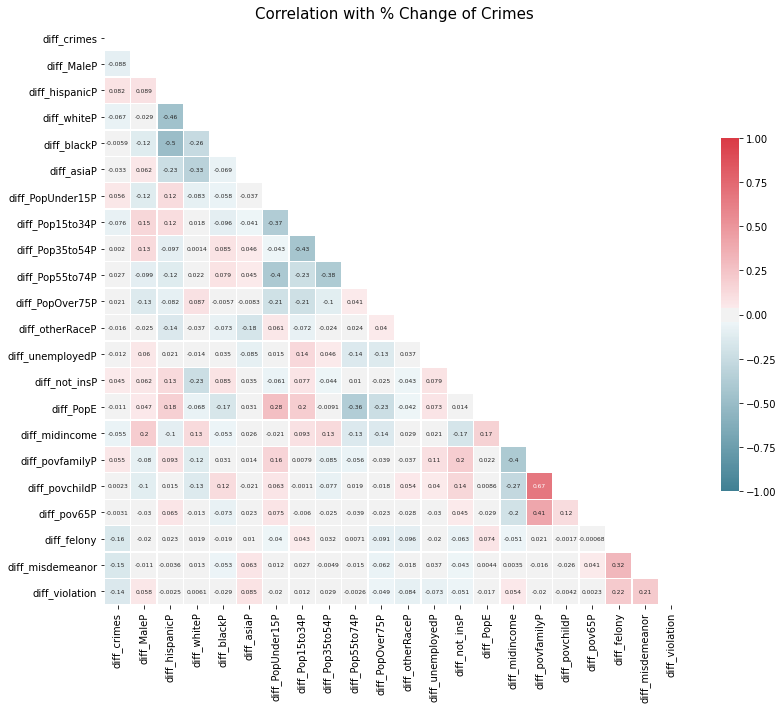

In [50]:
# corrMatrix = df_model_time_nta.corr()
# sns.heatmap(corrMatrix)
# plt.show()

corrMatrix = df_model_time_nta.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(13, 13))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5},
            annot=True, annot_kws={"size": 6})
plt.title('Correlation with % Change of Crimes', fontsize=15)
plt.show()

## Monthly analysis

In [0]:
# Sort by NTA, year, month
df_time = df_time.sort_values(['NTACode','year','month']) # Sort
# Calc change of #crimes
df_diff_crime = df_time[['num_crimes']].pct_change()
df_diff_crime.rename(columns = {'num_crimes':'diff_crimes'},inplace=True)
# Calc change of kinds of crime
df_diff_kind = df_time[['num_felony','num_misdemeanor','num_violation']].pct_change().shift(1)
df_diff_kind.rename(columns = {'num_felony':'diff_felony','num_misdemeanor':'diff_misdemeanor',
                               'num_violation':'diff_violation'},inplace=True)

In [52]:
df_diff_kind.head()

,diff_felony,diff_misdemeanor,diff_violation
index,,,
2012_BK09-1,NaN,NaN,NaN
2012_BK09-2,NaN,NaN,NaN
2012_BK09-3,-0.173913,-0.266667,0.600000
2012_BK09-4,-0.263158,-0.454545,0.625000
2012_BK09-5,-0.285714,0.777778,-0.692308


In [53]:
df_model_time = df_time.join(df_diff_crime['diff_crimes'])
df_model_time = df_model_time.join(df_diff_kind[['diff_felony','diff_misdemeanor','diff_violation']])
df_model_time.reset_index(inplace=True)
df_model_time.head()

,index,num_crimes,year,month,nta_index,NTACode,num_felony,num_misdemeanor,num_violation,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
0,2012_BK09-1,73,2012,1,2012_BK09,BK09,23,45,5.0,NaN,NaN,NaN,NaN
1,2012_BK09-2,60,2012,2,2012_BK09,BK09,19,33,8.0,-0.178082,NaN,NaN,NaN
2,2012_BK09-3,45,2012,3,2012_BK09,BK09,14,18,13.0,-0.250000,-0.173913,-0.266667,0.600000
3,2012_BK09-4,46,2012,4,2012_BK09,BK09,10,32,4.0,0.022222,-0.263158,-0.454545,0.625000
4,2012_BK09-5,66,2012,5,2012_BK09,BK09,21,36,9.0,0.434783,-0.285714,0.777778,-0.692308


In [0]:
df_model_time = df_model_time[df_model_time['year'] > 2012]

In [55]:
# Checking n/a data and zero
df_model_time.describe()

,num_crimes,year,month,num_felony,num_misdemeanor,num_violation,diff_crimes,diff_felony,diff_misdemeanor,diff_violation
count,11280.000000,11280.000000,11280.000000,11280.000000,11280.000000,11268.000000,11280.000000,11280.000000,11280.000000,11280.000000
mean,211.116755,2015.000000,6.500000,65.346543,117.658333,28.141818,0.014156,0.036222,0.027080,0.087460
std,159.360144,1.414276,3.452206,51.768349,92.411452,20.394053,0.179312,0.295453,0.249420,0.505582
min,7.000000,2013.000000,1.000000,3.000000,1.000000,1.000000,-0.714286,-0.785714,-0.937500,-0.909091
25%,93.000000,2014.000000,3.750000,28.000000,49.000000,13.000000,-0.098049,-0.142857,-0.120000,-0.193548
50%,179.000000,2015.000000,6.500000,54.000000,99.000000,23.000000,0.000000,0.000000,0.000000,0.000000
75%,279.000000,2016.000000,9.250000,87.000000,157.000000,38.000000,0.106411,0.166667,0.140496,0.250000
max,1348.000000,2017.000000,12.000000,499.000000,791.000000,157.000000,1.333333,3.800000,6.000000,9.000000


In [0]:
df_model_time.to_csv(r'/content/drive/Shared drives/STATS_507_Fianl_Project/NYPD_Crime/model_time_month.csv',index=False)

In [0]:
df_model_time.drop(columns=['index','num_crimes','year','month','nta_index',
                             'NTACode','num_felony','num_misdemeanor','num_violation'],inplace=True)

In [0]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [59]:
results = smf.ols('diff_crimes ~ diff_felony + diff_misdemeanor	+ diff_violation', data=df_model_time).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            diff_crimes   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     662.9
Date:                Sun, 26 Apr 2020   Prob (F-statistic):               0.00
Time:                        20:41:32   Log-Likelihood:                 4297.2
No. Observations:               11280   AIC:                            -8586.
Df Residuals:                   11276   BIC:                            -8557.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0267      0.002  

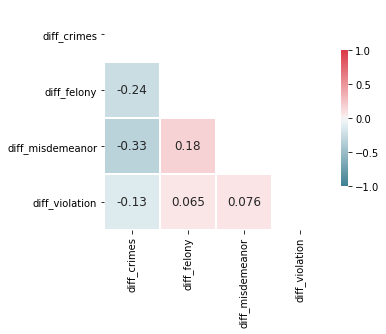

In [60]:
# corrMatrix = df_model_time.corr()
# sns.heatmap(corrMatrix, annot=True)
# plt.show()

corrMatrix = df_model_time.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrMatrix, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(5, 5))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrMatrix, mask=mask, cmap=cmap,vmin=-1, vmax=1, center=0,
            square=True, linewidths=.3, cbar_kws={"shrink": .5},
            annot=True, annot_kws={"size": 12})
plt.show()